This project will primarily focus on using time series forcasting to predict order demand from a dataset that contains the order history of numberous different products. (dataset available here: https://www.kaggle.com/felixzhao/productdemandforecasting) This project will primarily be focusing on four different products that were picked after eyeballing any potential trends and using two different forcasting techniques: decomposition and gradient-boosted regression. 

In [85]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit

In [29]:
df = pd.read_csv(r'Historical Product Demand.csv', parse_dates = ['Date'])
df

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012-07-27,100
1,Product_0979,Whse_J,Category_028,2012-01-19,500
2,Product_0979,Whse_J,Category_028,2012-02-03,500
3,Product_0979,Whse_J,Category_028,2012-02-09,500
4,Product_0979,Whse_J,Category_028,2012-03-02,500
...,...,...,...,...,...
1048570,Product_1791,Whse_J,Category_006,2016-04-27,1000
1048571,Product_1974,Whse_J,Category_006,2016-04-27,1
1048572,Product_1787,Whse_J,Category_006,2016-04-28,2500
1048573,Product_0901,Whse_J,Category_023,2016-10-07,50


In [30]:
#To get a preliminary view on how many unique values were in each category, I wanted to use the nunique command
print(df['Product_Category'].nunique())
print(df['Product_Code'].nunique())
print(df['Order_Demand'].nunique())

33
2160
3828


In [31]:
df.dtypes

Product_Code                object
Warehouse                   object
Product_Category            object
Date                datetime64[ns]
Order_Demand                object
dtype: object

In [32]:
#Here I wanted to view how many rows had parenthesized values from the dataset. After looking through the raw .csv file, I realized that the negative values had been encased in parentheses
check = df['Order_Demand'].str.contains(')', regex=False)
df_check = df[check == True]
df_check

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
112290,Product_2169,Whse_A,Category_024,2012-08-09,(1)
112307,Product_2132,Whse_A,Category_009,2012-11-01,(24)
112308,Product_2144,Whse_A,Category_009,2012-11-01,(24)
112356,Product_2118,Whse_A,Category_009,2012-03-07,(50)
112357,Product_2120,Whse_A,Category_009,2012-03-07,(100)
...,...,...,...,...,...
1047812,Product_1887,Whse_J,Category_007,2016-06-30,(100)
1047840,Product_0092,Whse_J,Category_019,2016-06-15,(400)
1047855,Product_0686,Whse_J,Category_011,2016-07-29,(230)
1047856,Product_0687,Whse_J,Category_011,2016-07-29,(230)


In [33]:
#To successfully convert the Order_Demand column into a column of integers, I wanted to get rid of the parentheses and put the minus signs back in.
df['Order_Demand'] = df['Order_Demand'].str.replace(r'(', '-')
df['Order_Demand'] = df['Order_Demand'].str.replace(r')', '')

print(df['Order_Demand'].nunique())


3828


In [34]:
df['Order_Demand'] = df['Order_Demand'].astype('int32')
df.dtypes

Product_Code                object
Warehouse                   object
Product_Category            object
Date                datetime64[ns]
Order_Demand                 int32
dtype: object

In [35]:
#To select the products that I wished to analyze, I wanted to look at the first 20 unique products and look at their basic trends.
all_products = df['Product_Code'].unique()
product_list = all_products.tolist()
small_list = product_list[1:20]
small_list

['Product_0979',
 'Product_1159',
 'Product_1938',
 'Product_1157',
 'Product_1234',
 'Product_1451',
 'Product_1274',
 'Product_1512',
 'Product_1970',
 'Product_1372',
 'Product_1994',
 'Product_0558',
 'Product_0560',
 'Product_0561',
 'Product_1183',
 'Product_1184',
 'Product_1150',
 'Product_1173',
 'Product_1900']

In [36]:
#Using the shortened product list, I appended all sales of the first 20 unique products to an empty dataframe that I will primarily use to analyze their trends
main = pd.DataFrame()
for product in small_list:
    product_rows = df[df['Product_Code'] == product]
    main = main.append(product_rows)
main

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
1,Product_0979,Whse_J,Category_028,2012-01-19,500
2,Product_0979,Whse_J,Category_028,2012-02-03,500
3,Product_0979,Whse_J,Category_028,2012-02-09,500
4,Product_0979,Whse_J,Category_028,2012-03-02,500
5,Product_0979,Whse_J,Category_028,2012-04-19,500
...,...,...,...,...,...
1001112,Product_1900,Whse_J,Category_019,2016-04-21,3000
1001116,Product_1900,Whse_J,Category_019,2016-08-04,3500
1001117,Product_1900,Whse_J,Category_019,2016-09-08,1000
1001118,Product_1900,Whse_J,Category_019,2016-11-01,2500


In [37]:
#At this point, I wanted to append the dates to the index to further integrate the dates into the dataset. Before doing this, I needed to see if there were any null values regarding dates so I could drop any rows that had no date.
print(main['Date'].isnull().sum())

main = main.dropna()
df.set_index('Date')

39


,Product_Code,Warehouse,Product_Category,Order_Demand
Date,,,,
2012-07-27,Product_0993,Whse_J,Category_028,100
2012-01-19,Product_0979,Whse_J,Category_028,500
2012-02-03,Product_0979,Whse_J,Category_028,500
2012-02-09,Product_0979,Whse_J,Category_028,500
2012-03-02,Product_0979,Whse_J,Category_028,500
...,...,...,...,...
2016-04-27,Product_1791,Whse_J,Category_006,1000
2016-04-27,Product_1974,Whse_J,Category_006,1
2016-04-28,Product_1787,Whse_J,Category_006,2500


In [38]:
#Since the product category and warehouse did not offer large information about the individual products, I decided that they were not necessary for this analysis.
main = main.drop(['Warehouse', 'Product_Category'], axis=1)
# main = main.sort_values(by='Date')
main

,Product_Code,Date,Order_Demand
1,Product_0979,2012-01-19,500
2,Product_0979,2012-02-03,500
3,Product_0979,2012-02-09,500
4,Product_0979,2012-03-02,500
5,Product_0979,2012-04-19,500
...,...,...,...
1001112,Product_1900,2016-04-21,3000
1001116,Product_1900,2016-08-04,3500
1001117,Product_1900,2016-09-08,1000
1001118,Product_1900,2016-11-01,2500


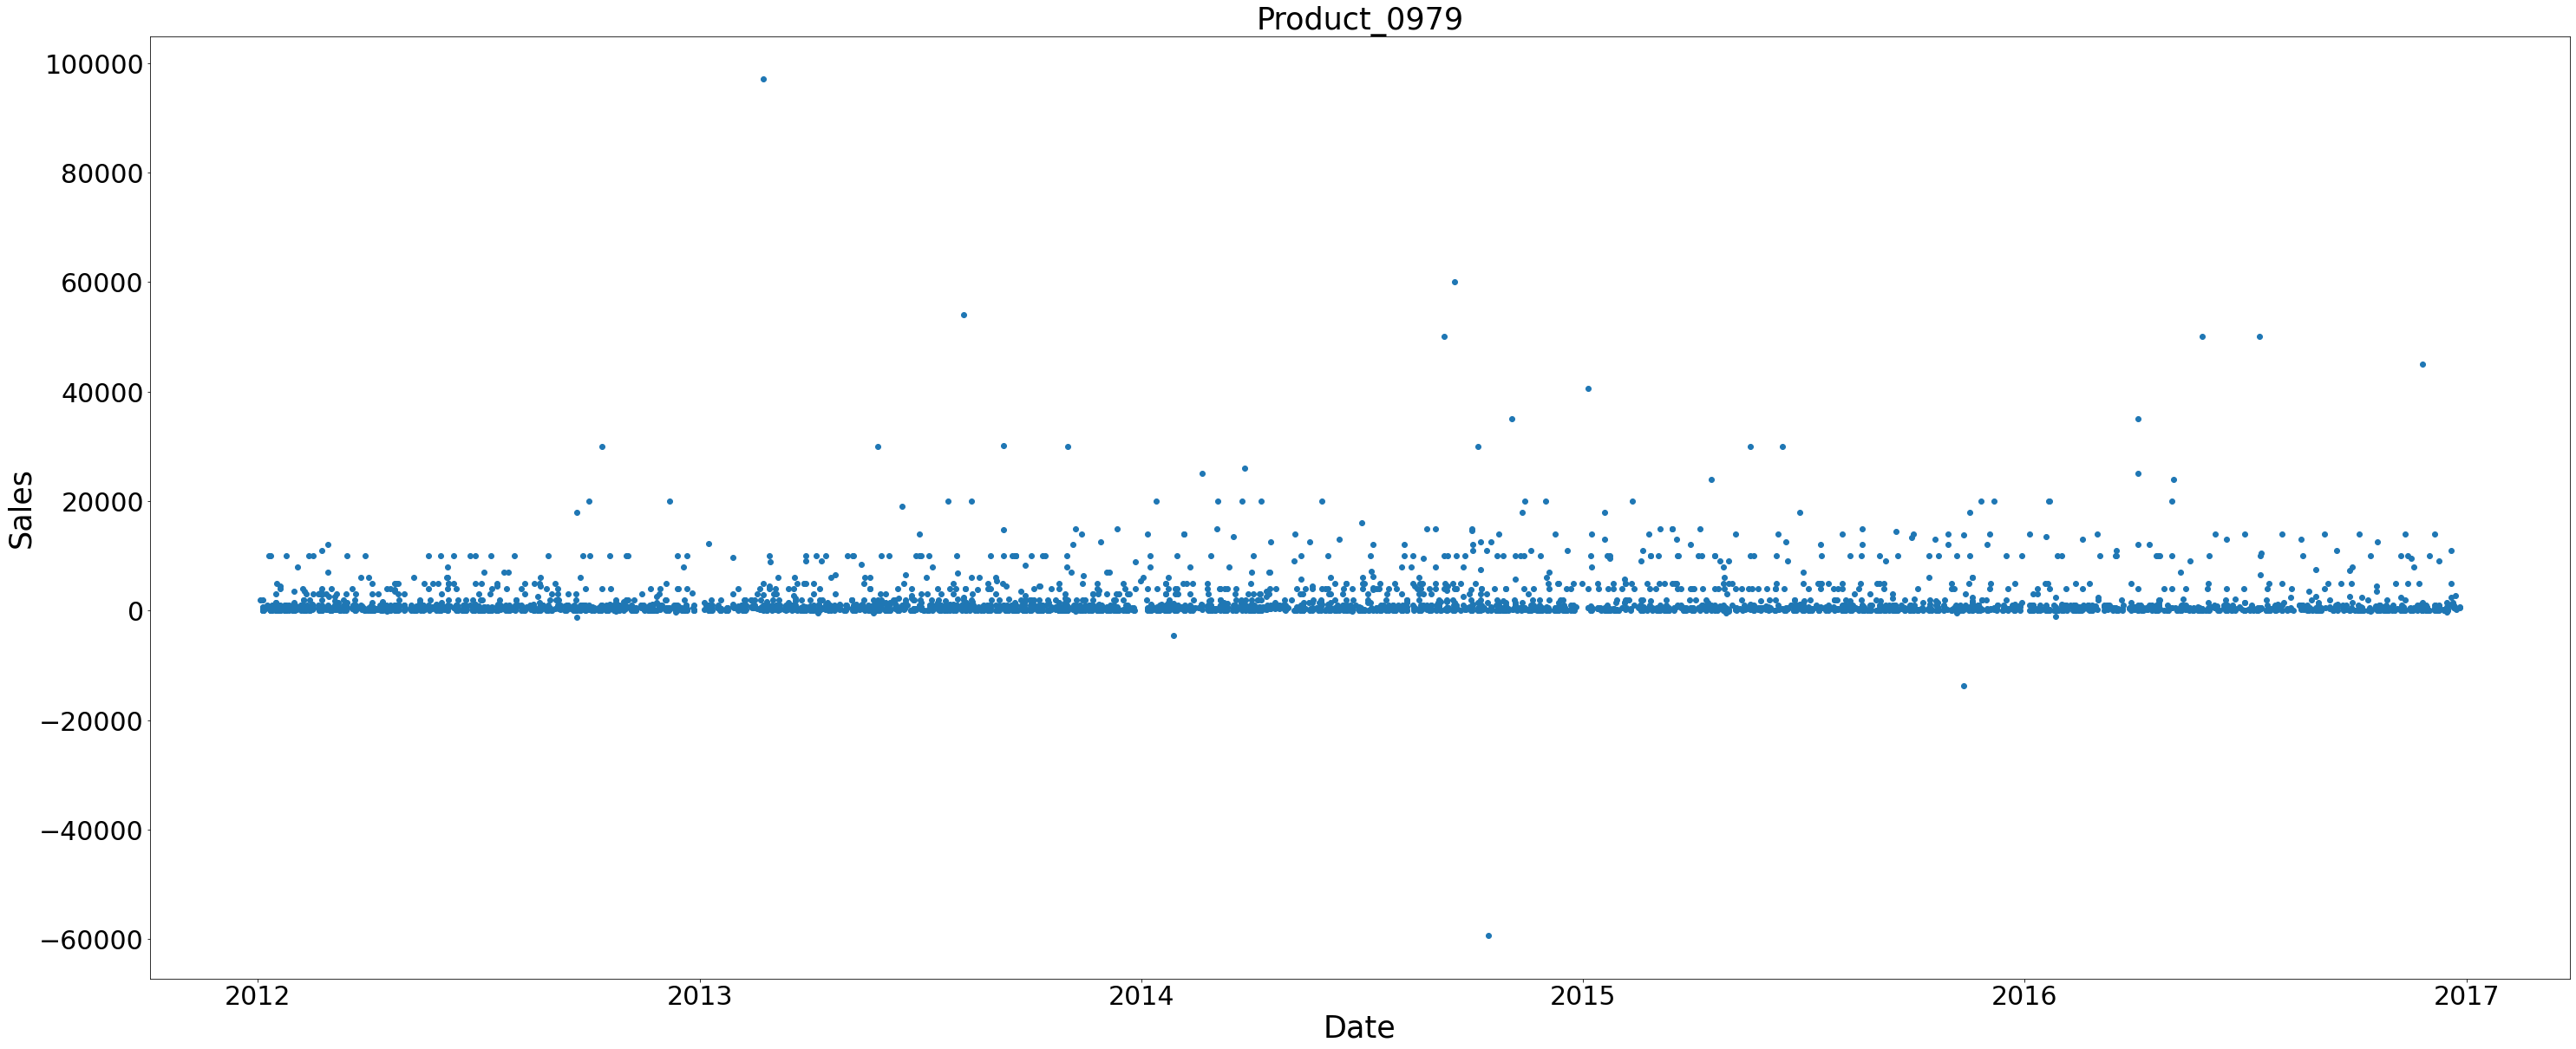

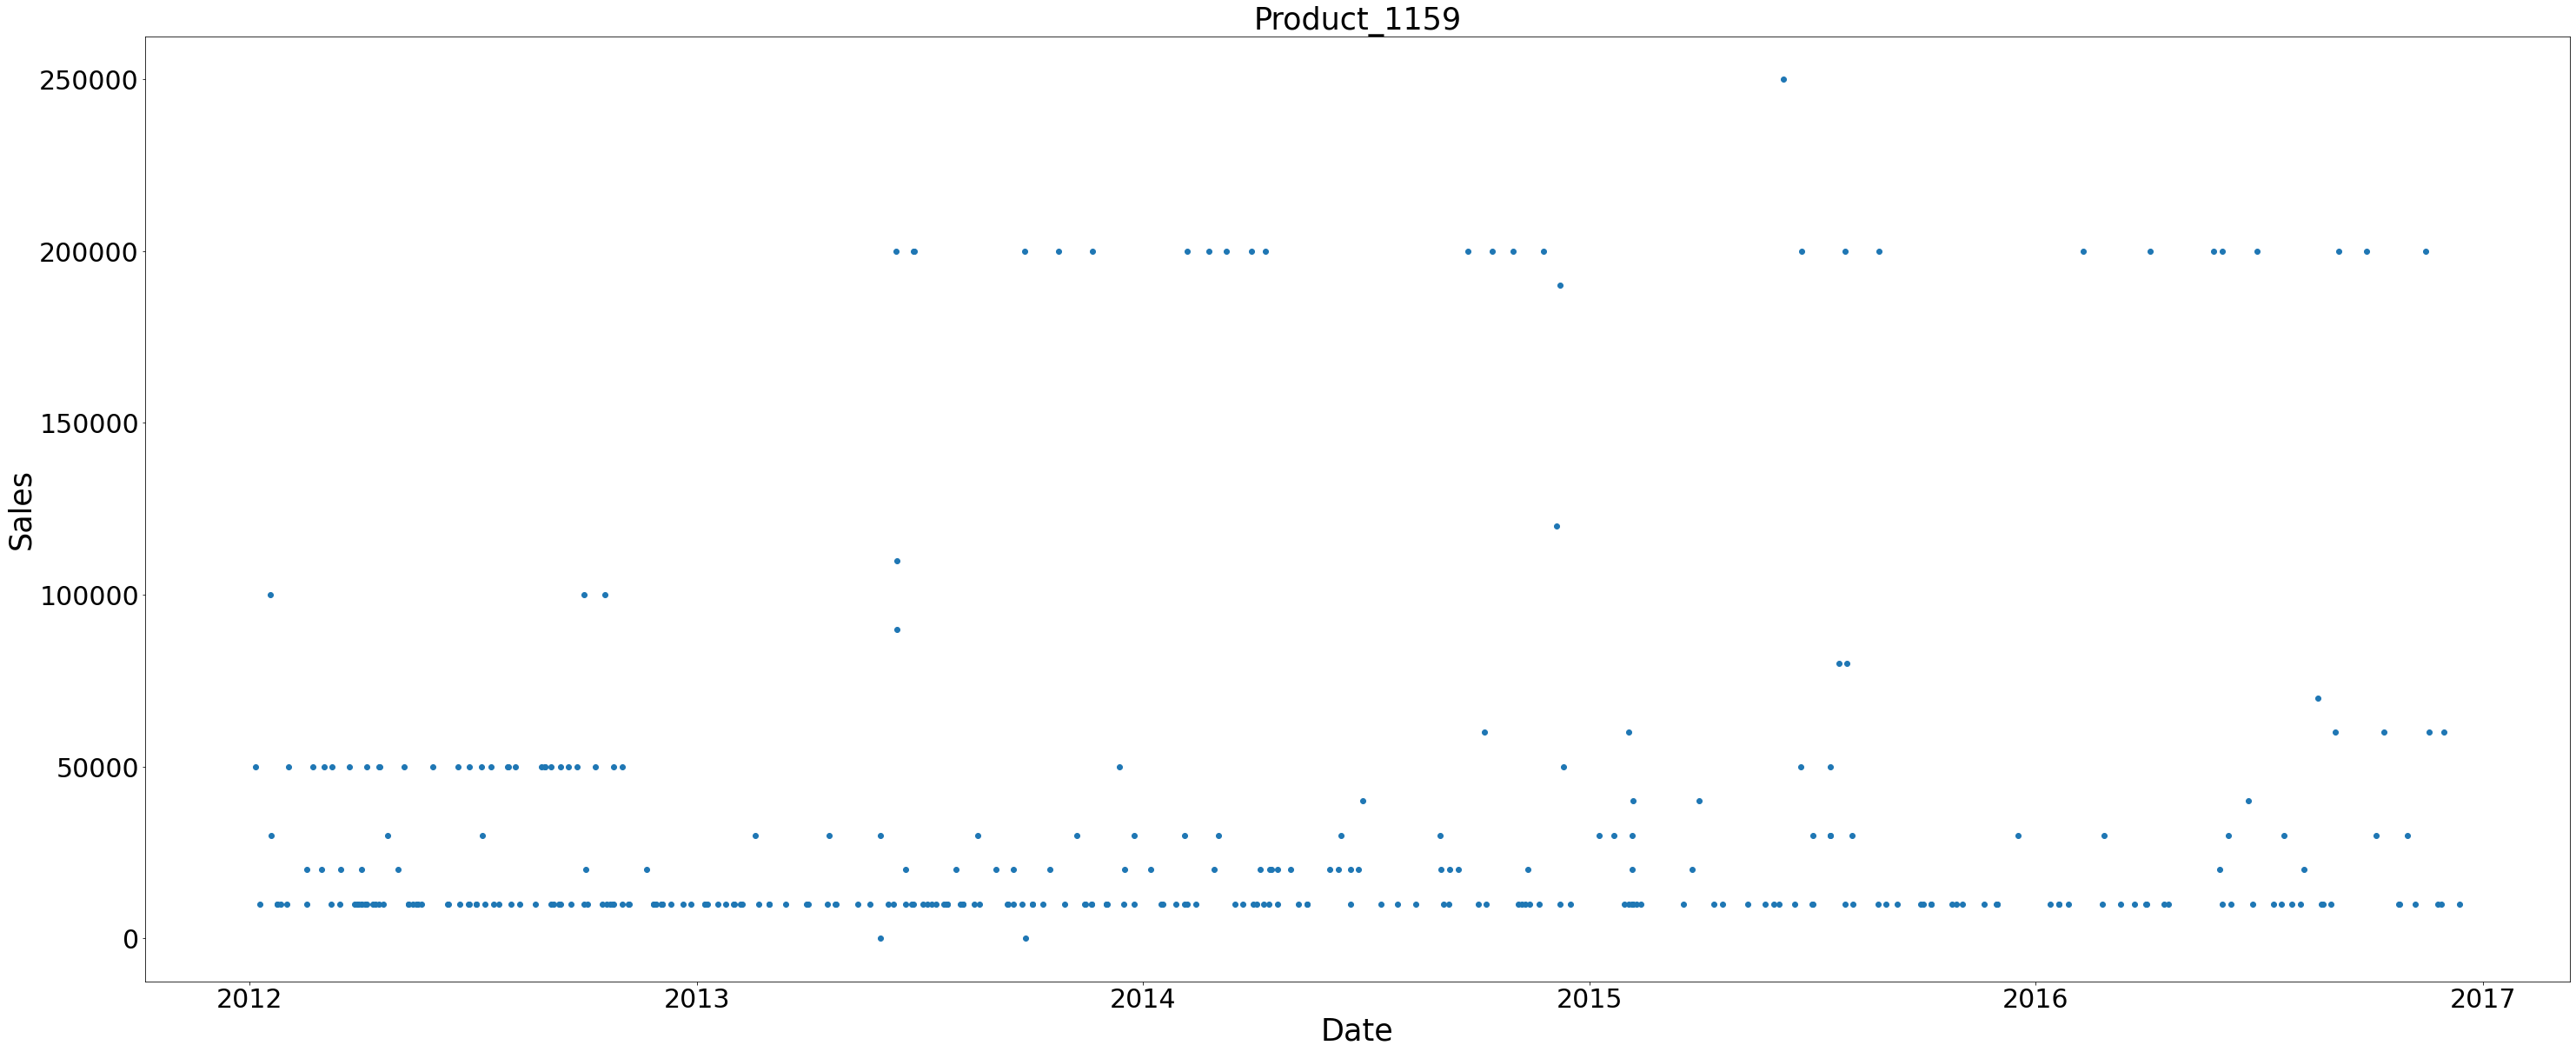

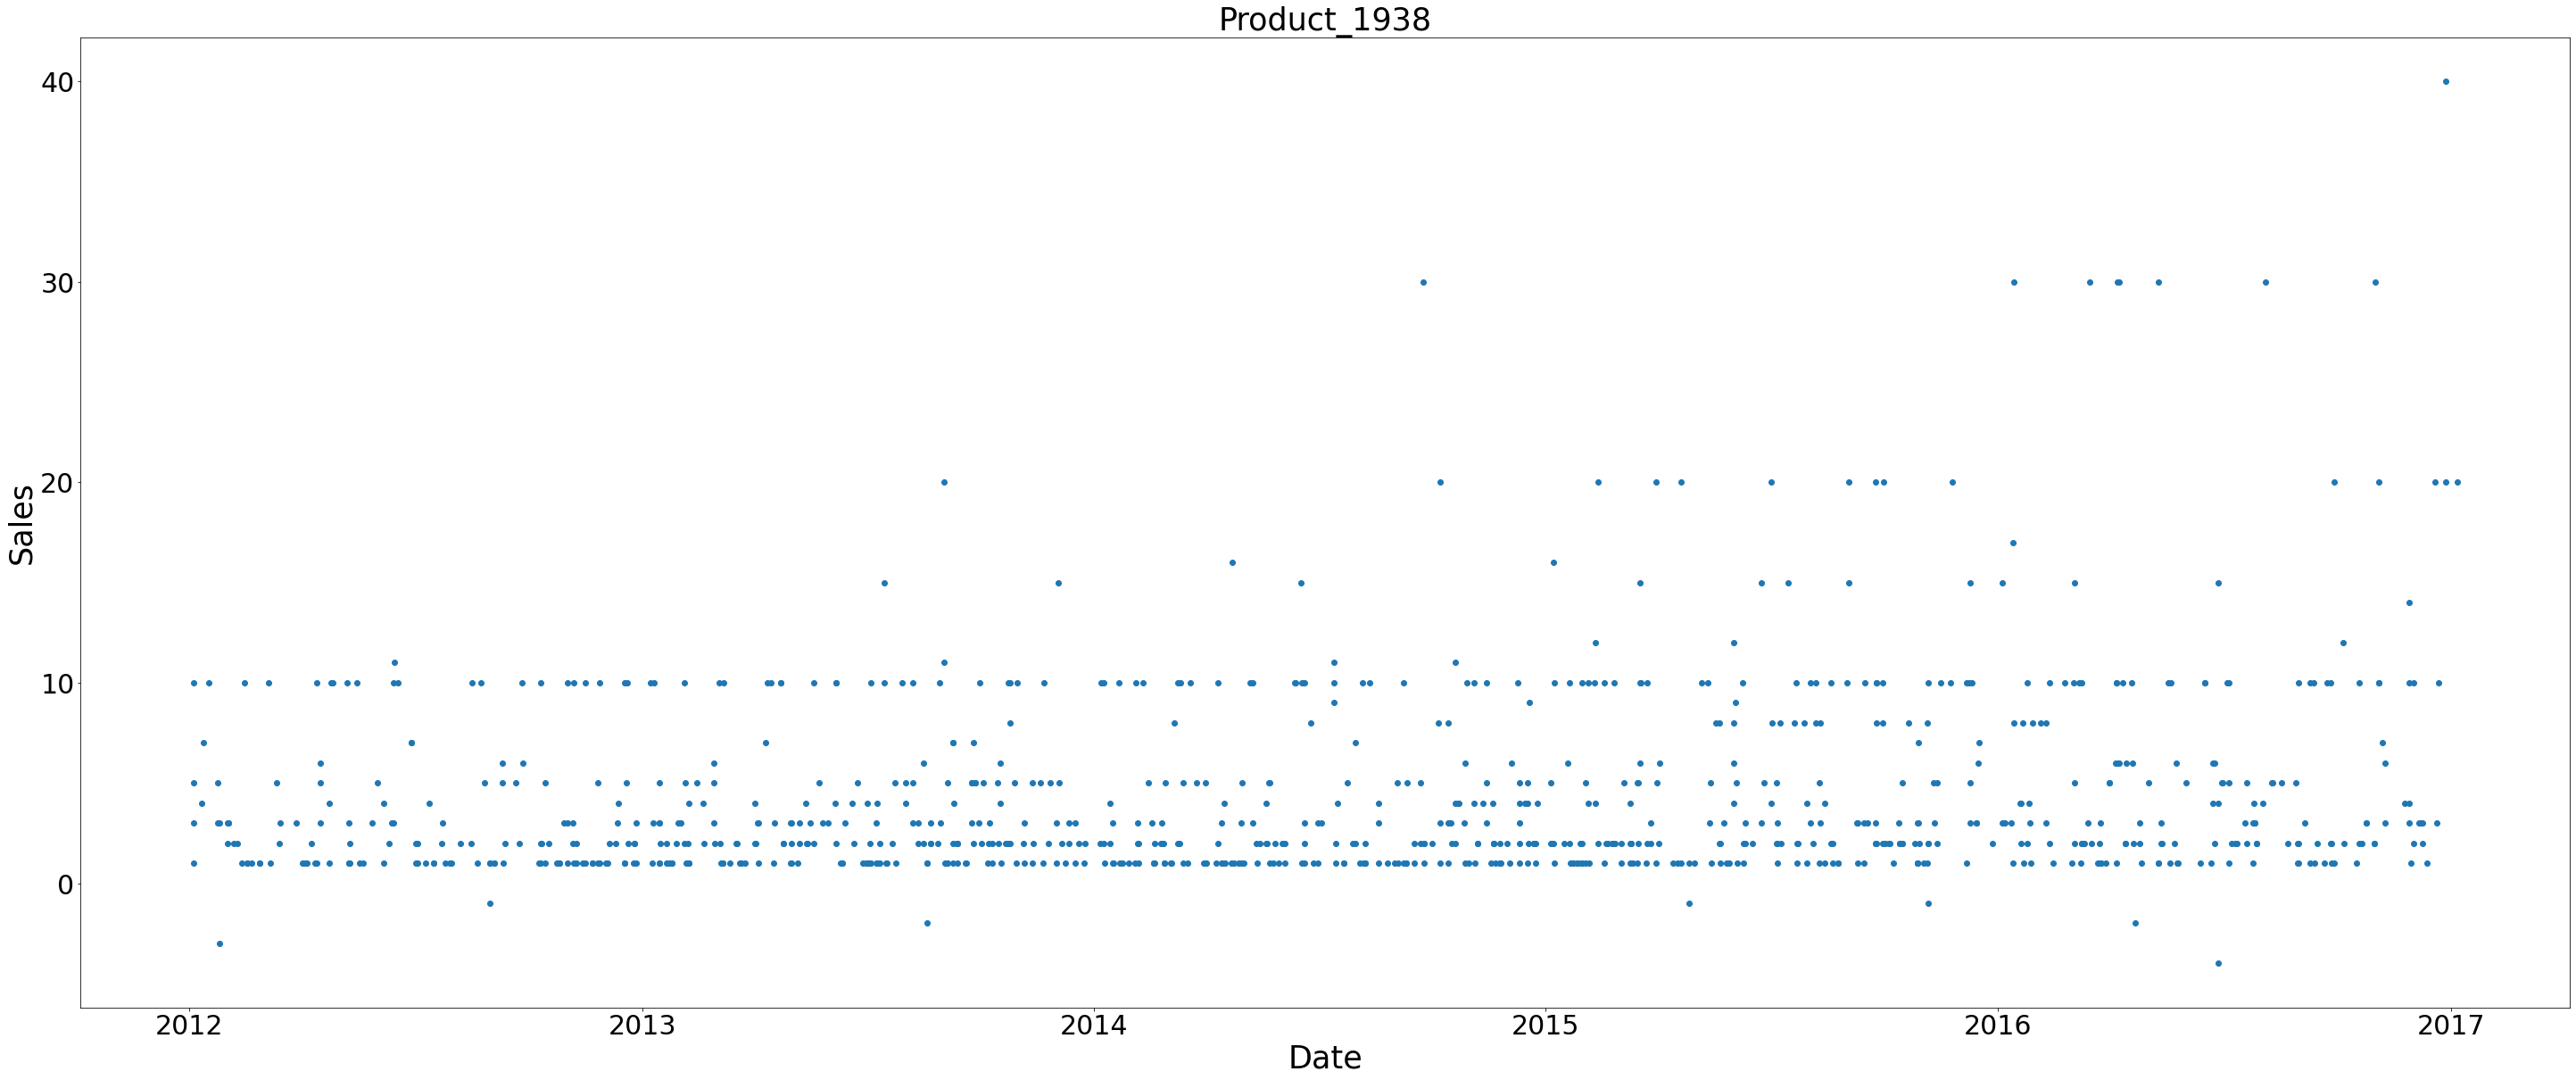

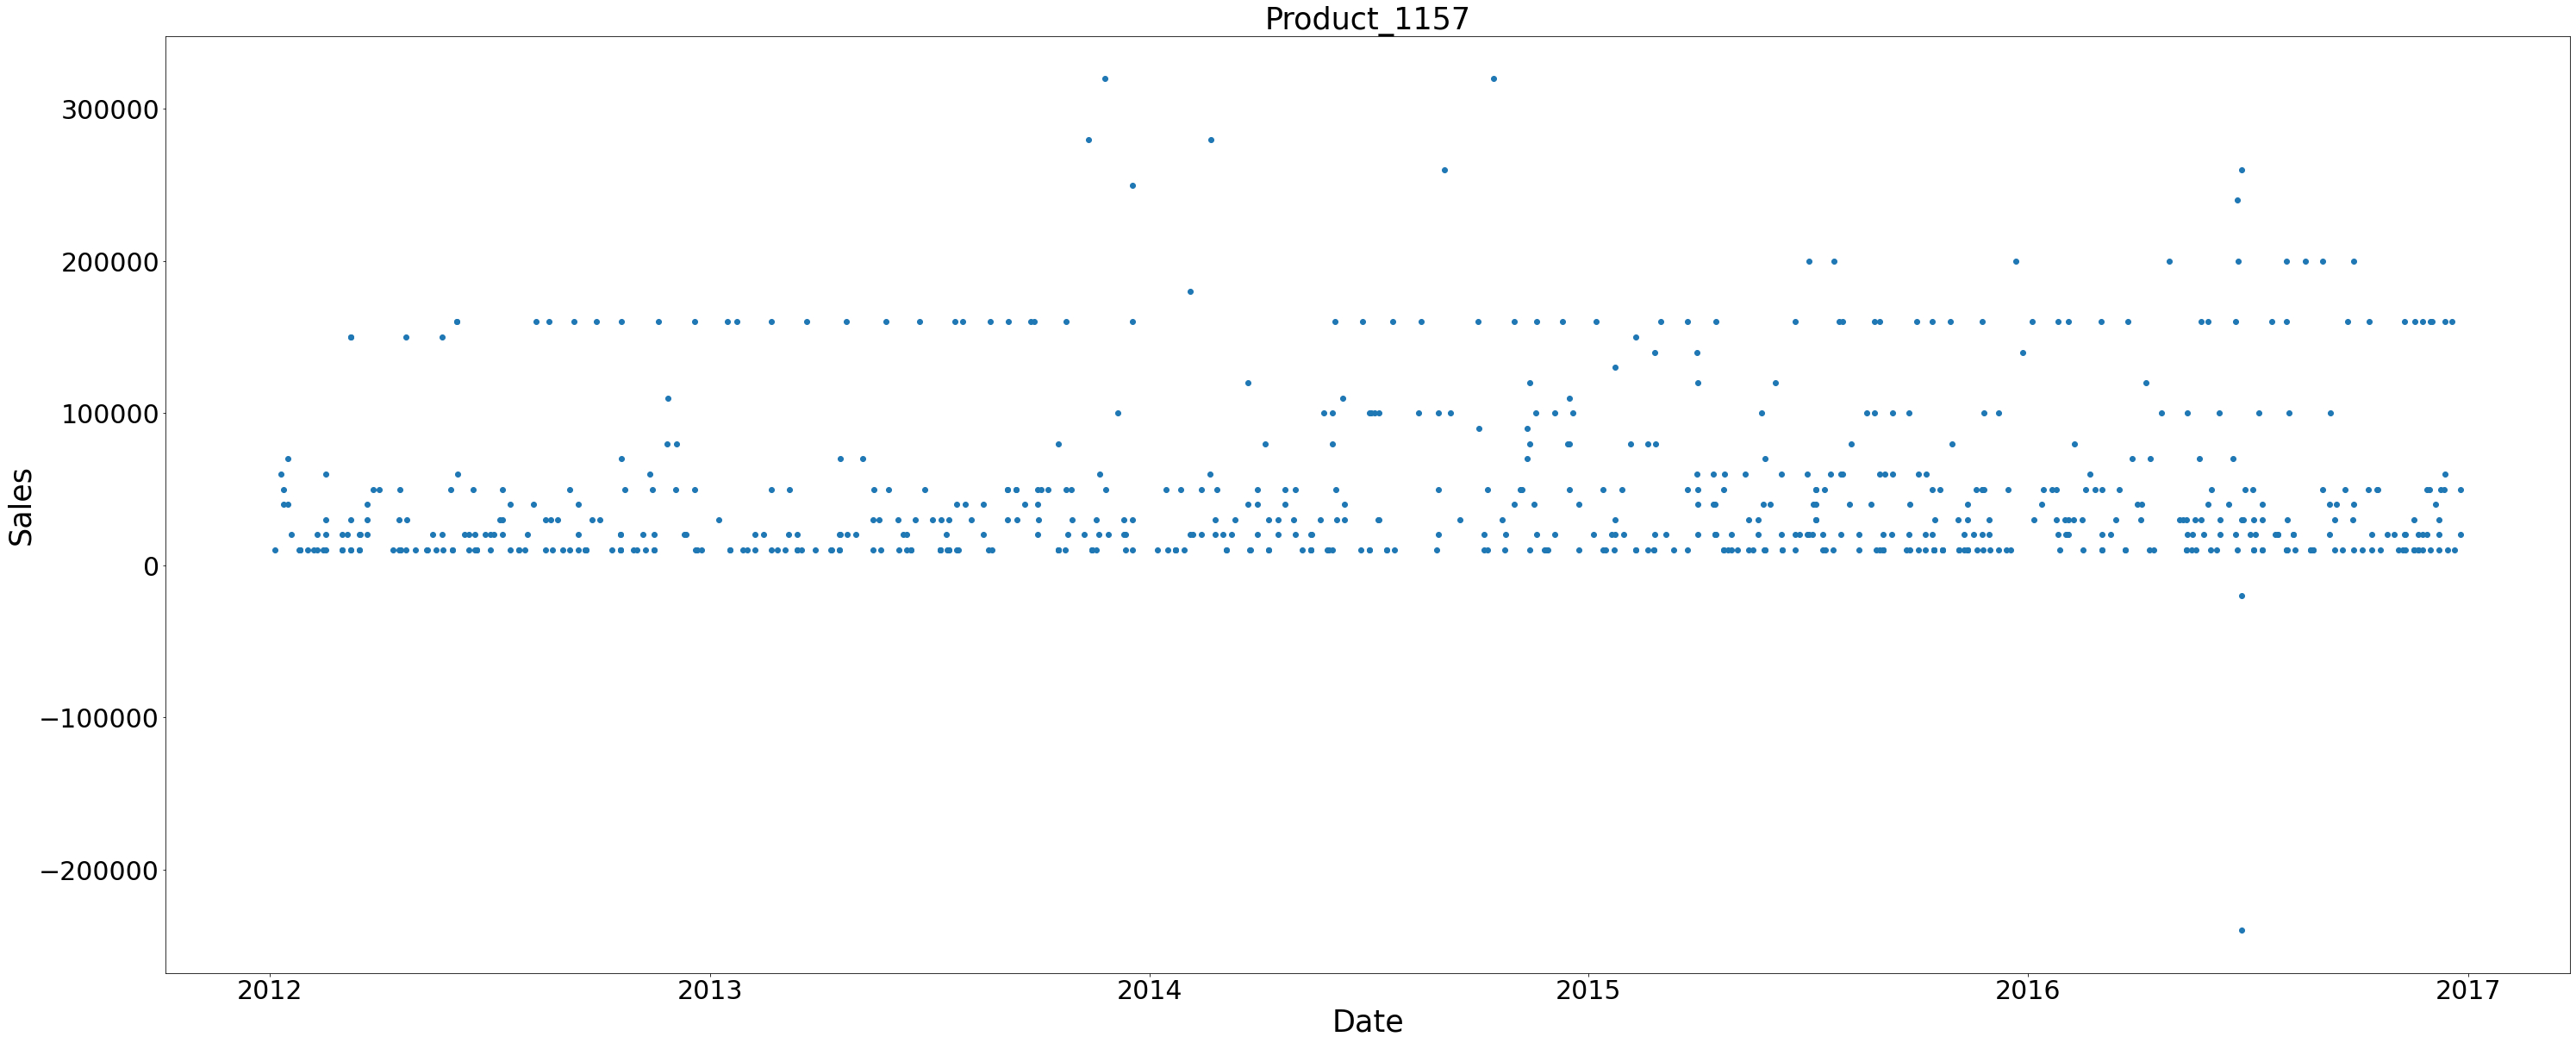

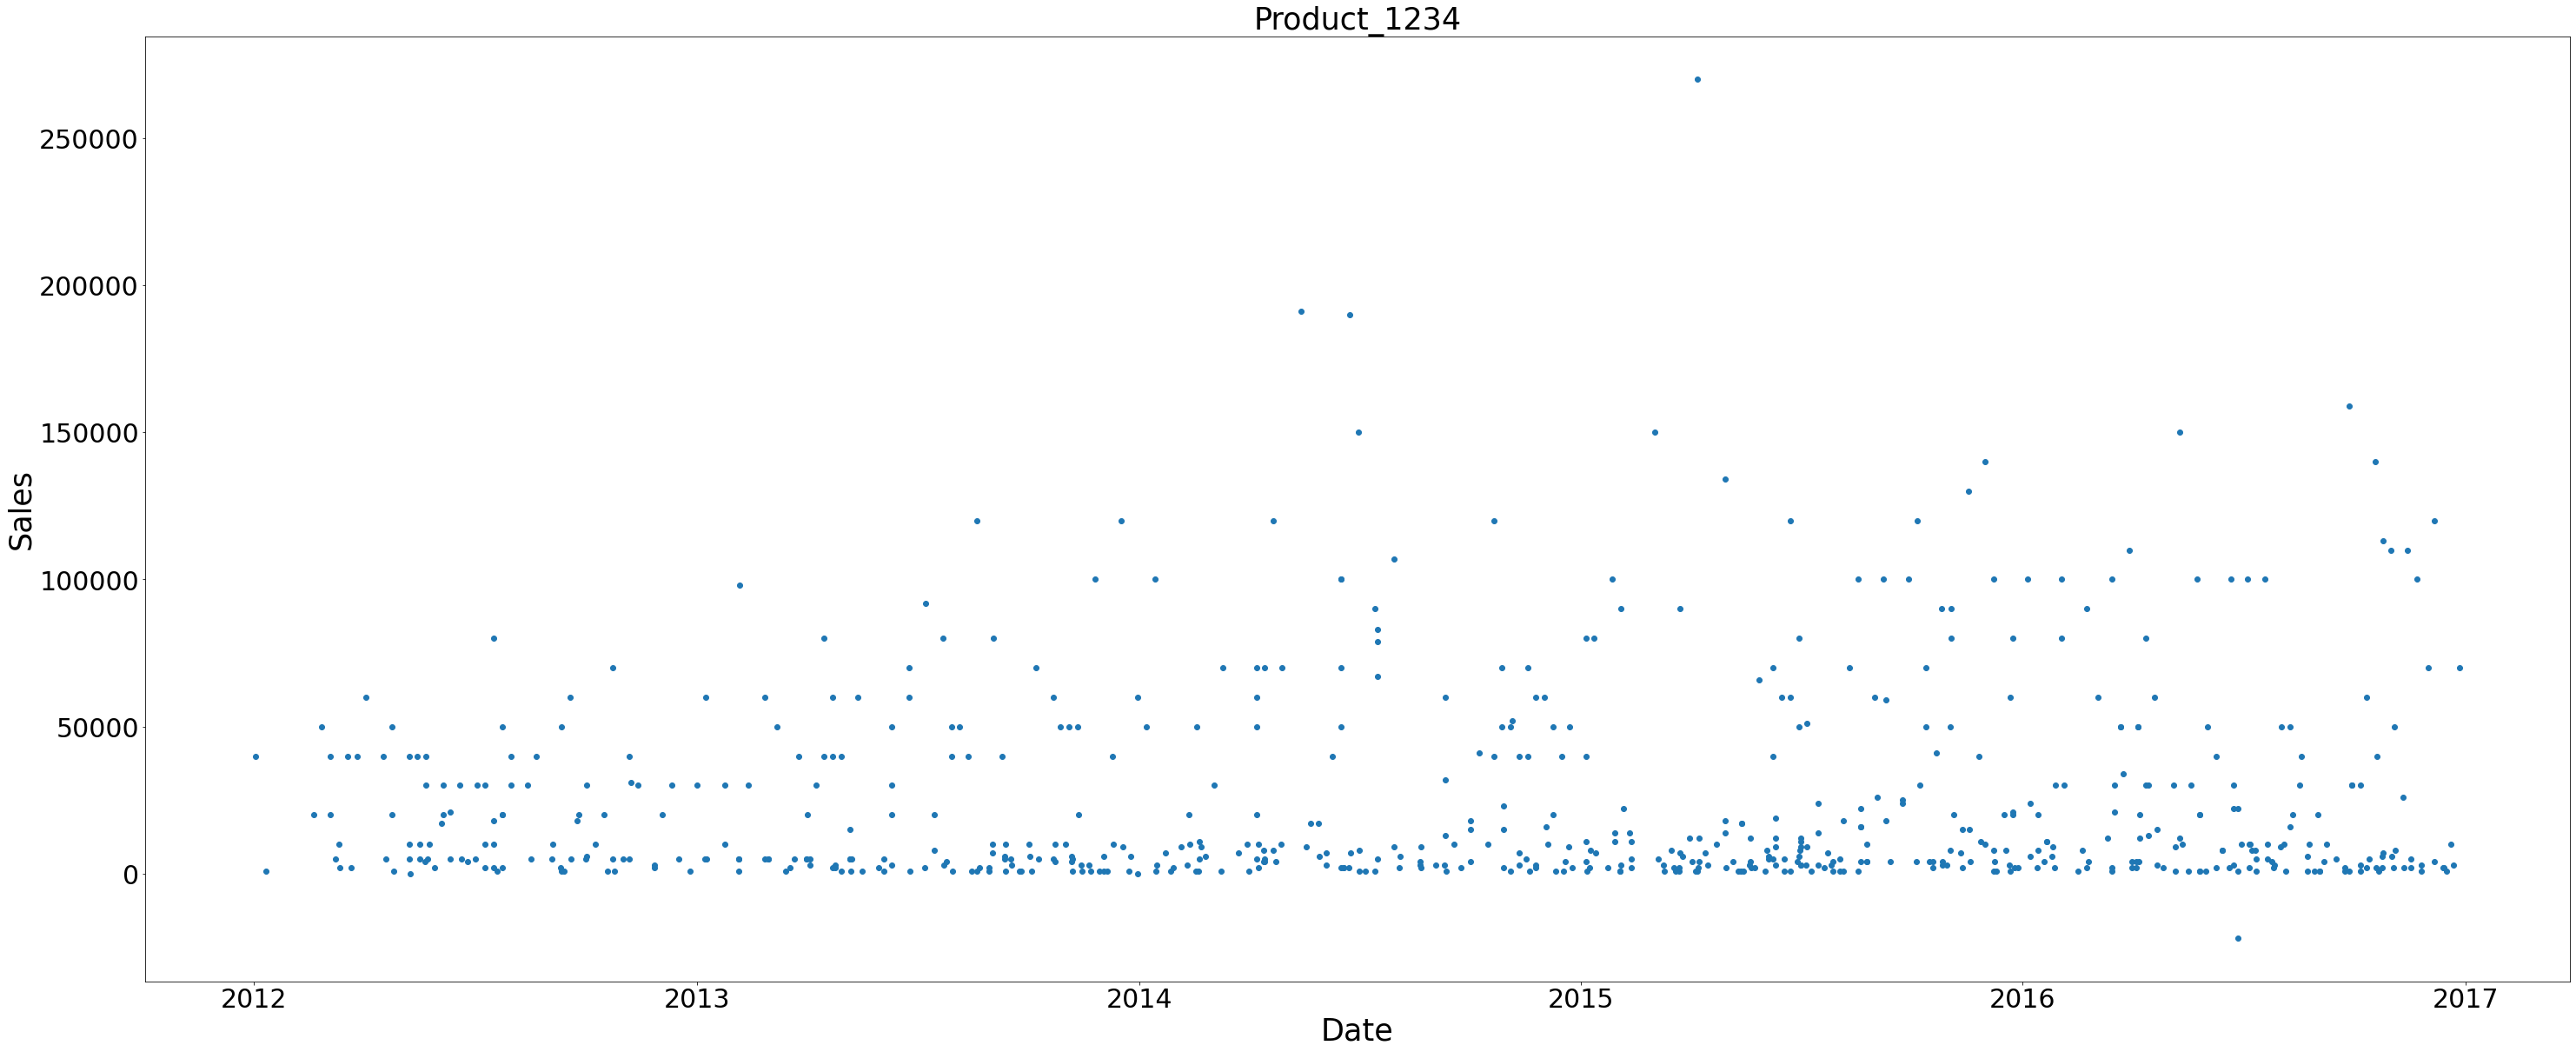

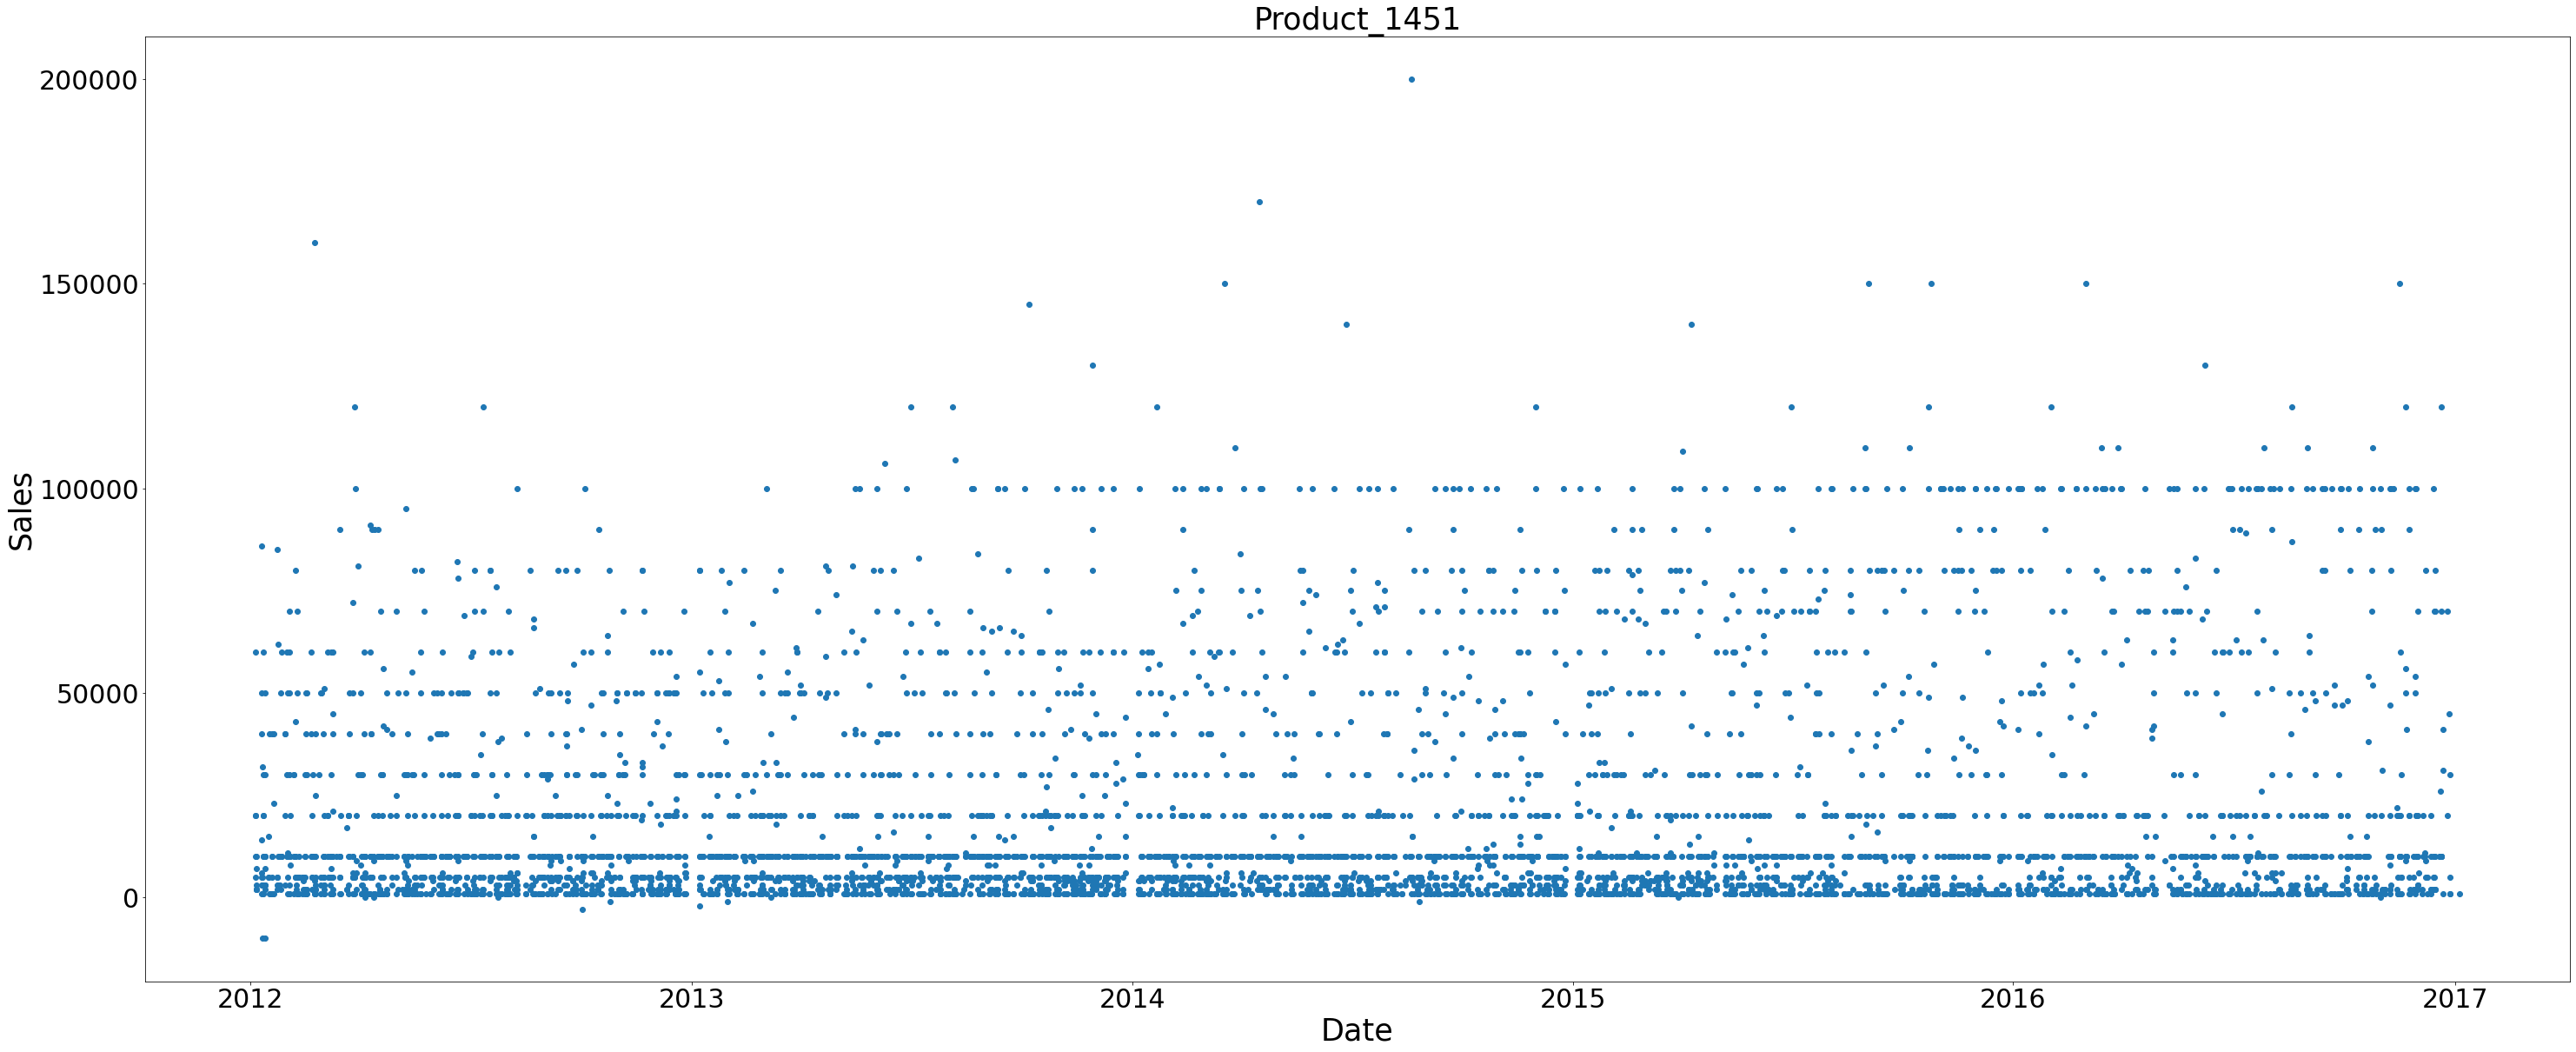

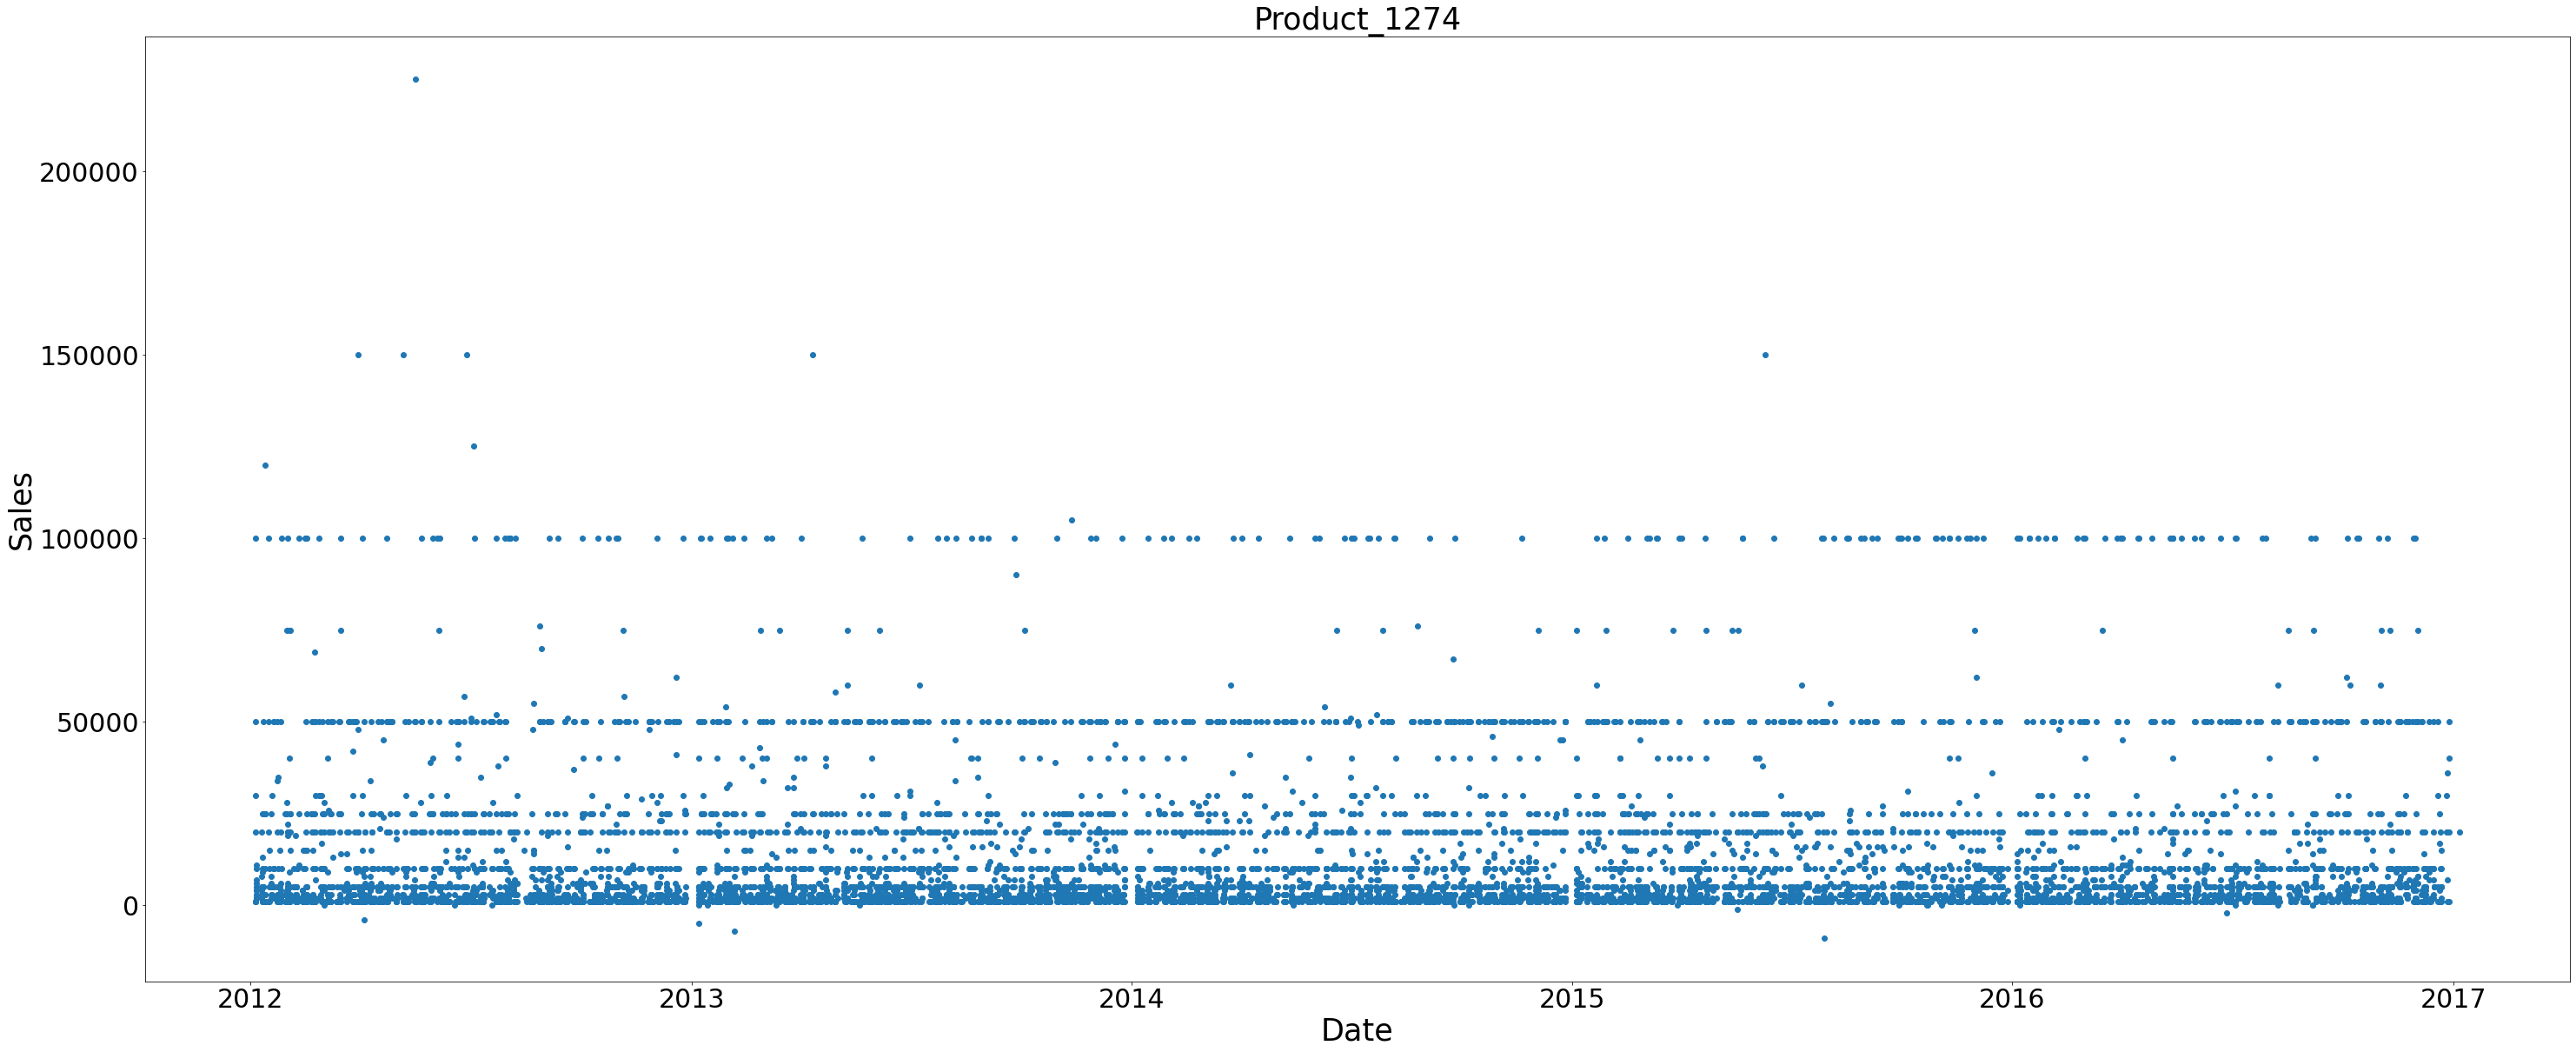

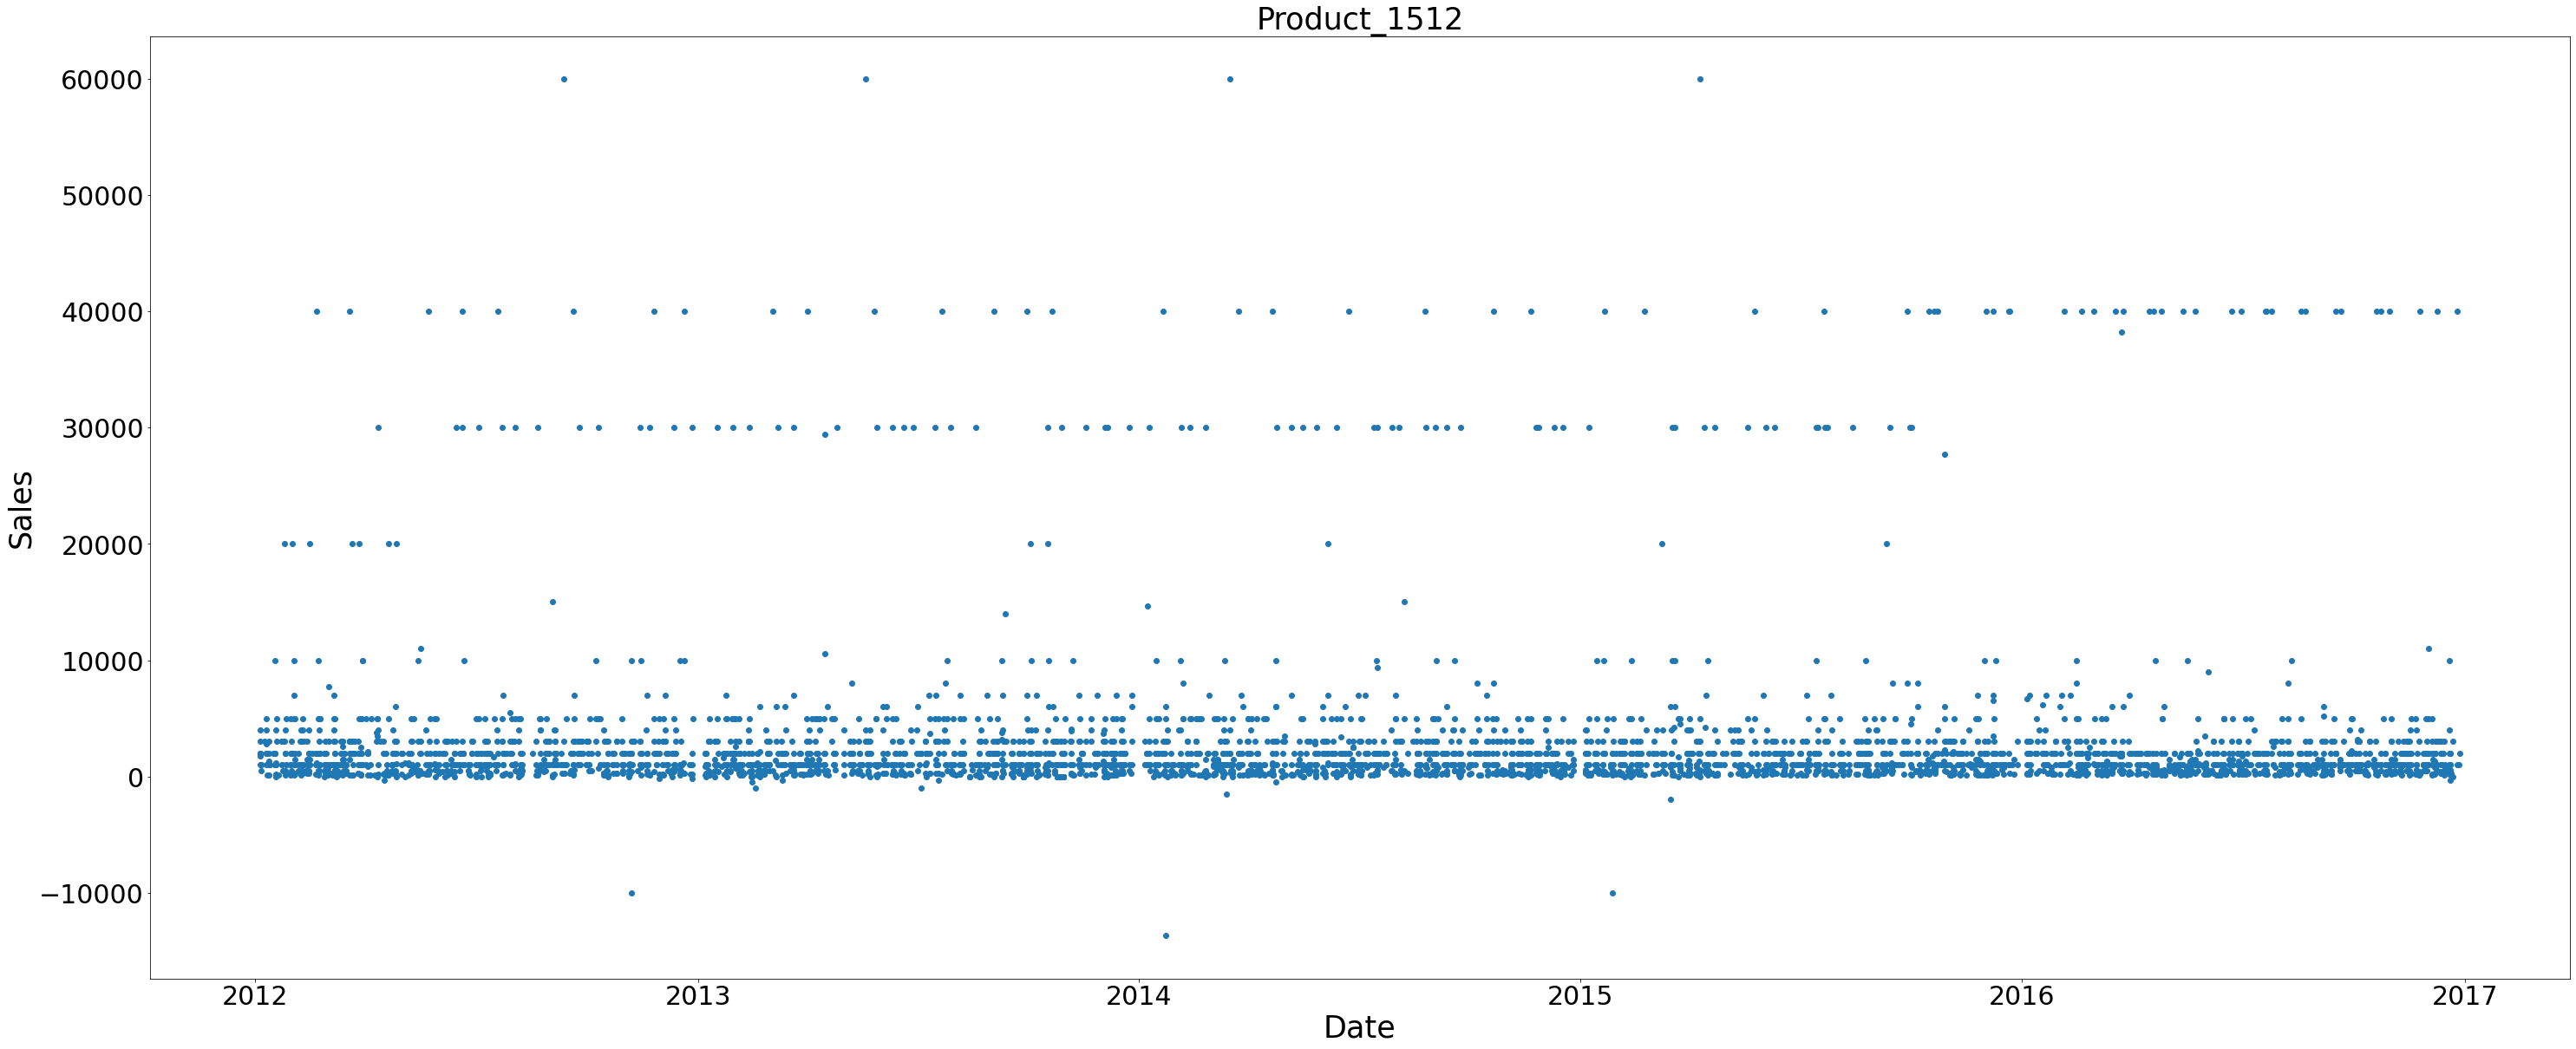

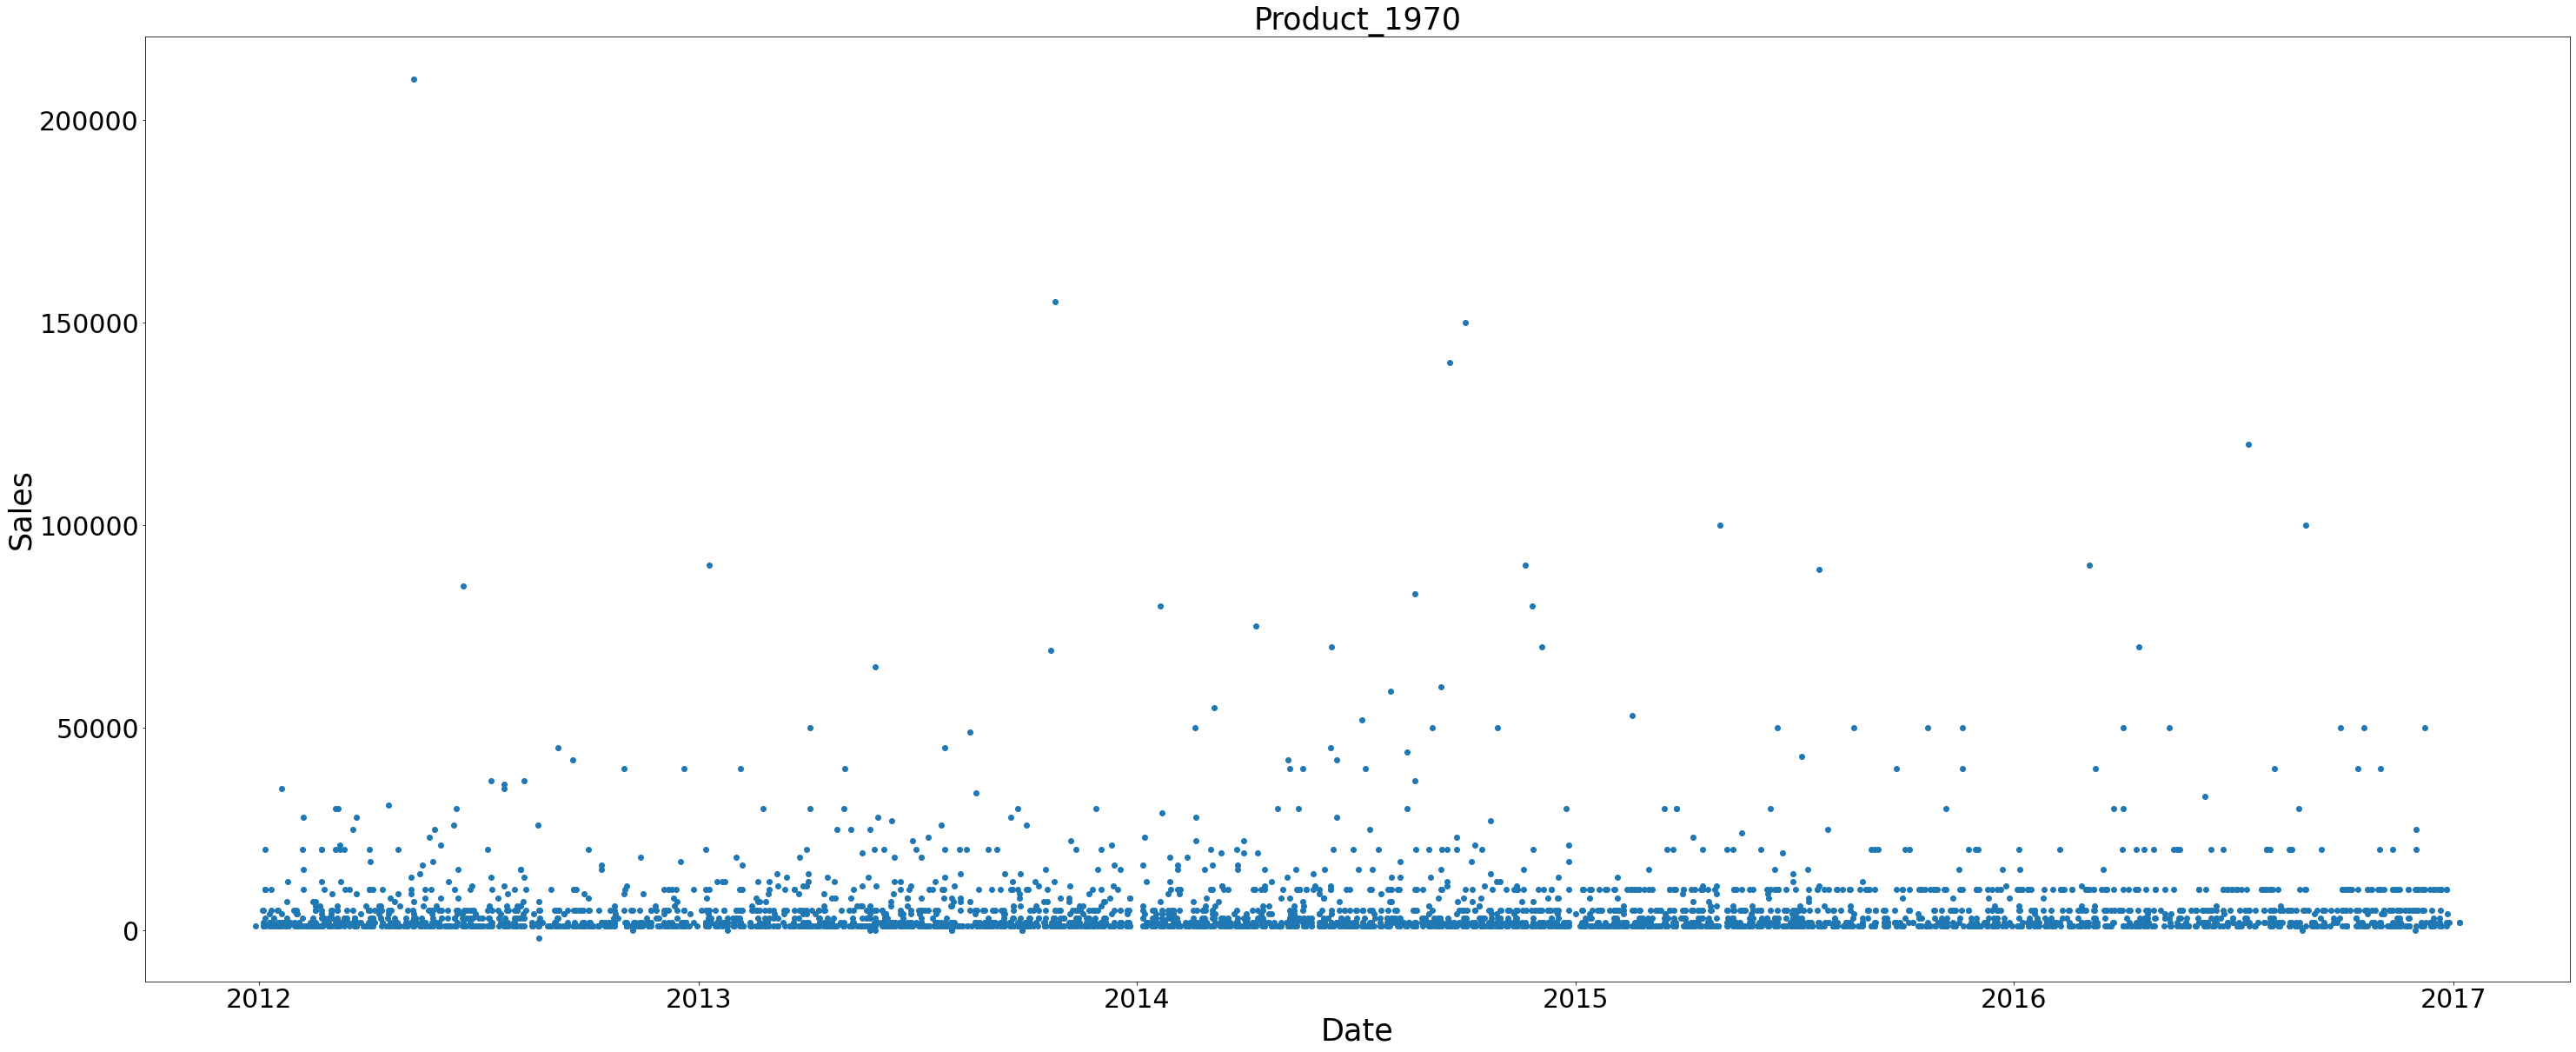

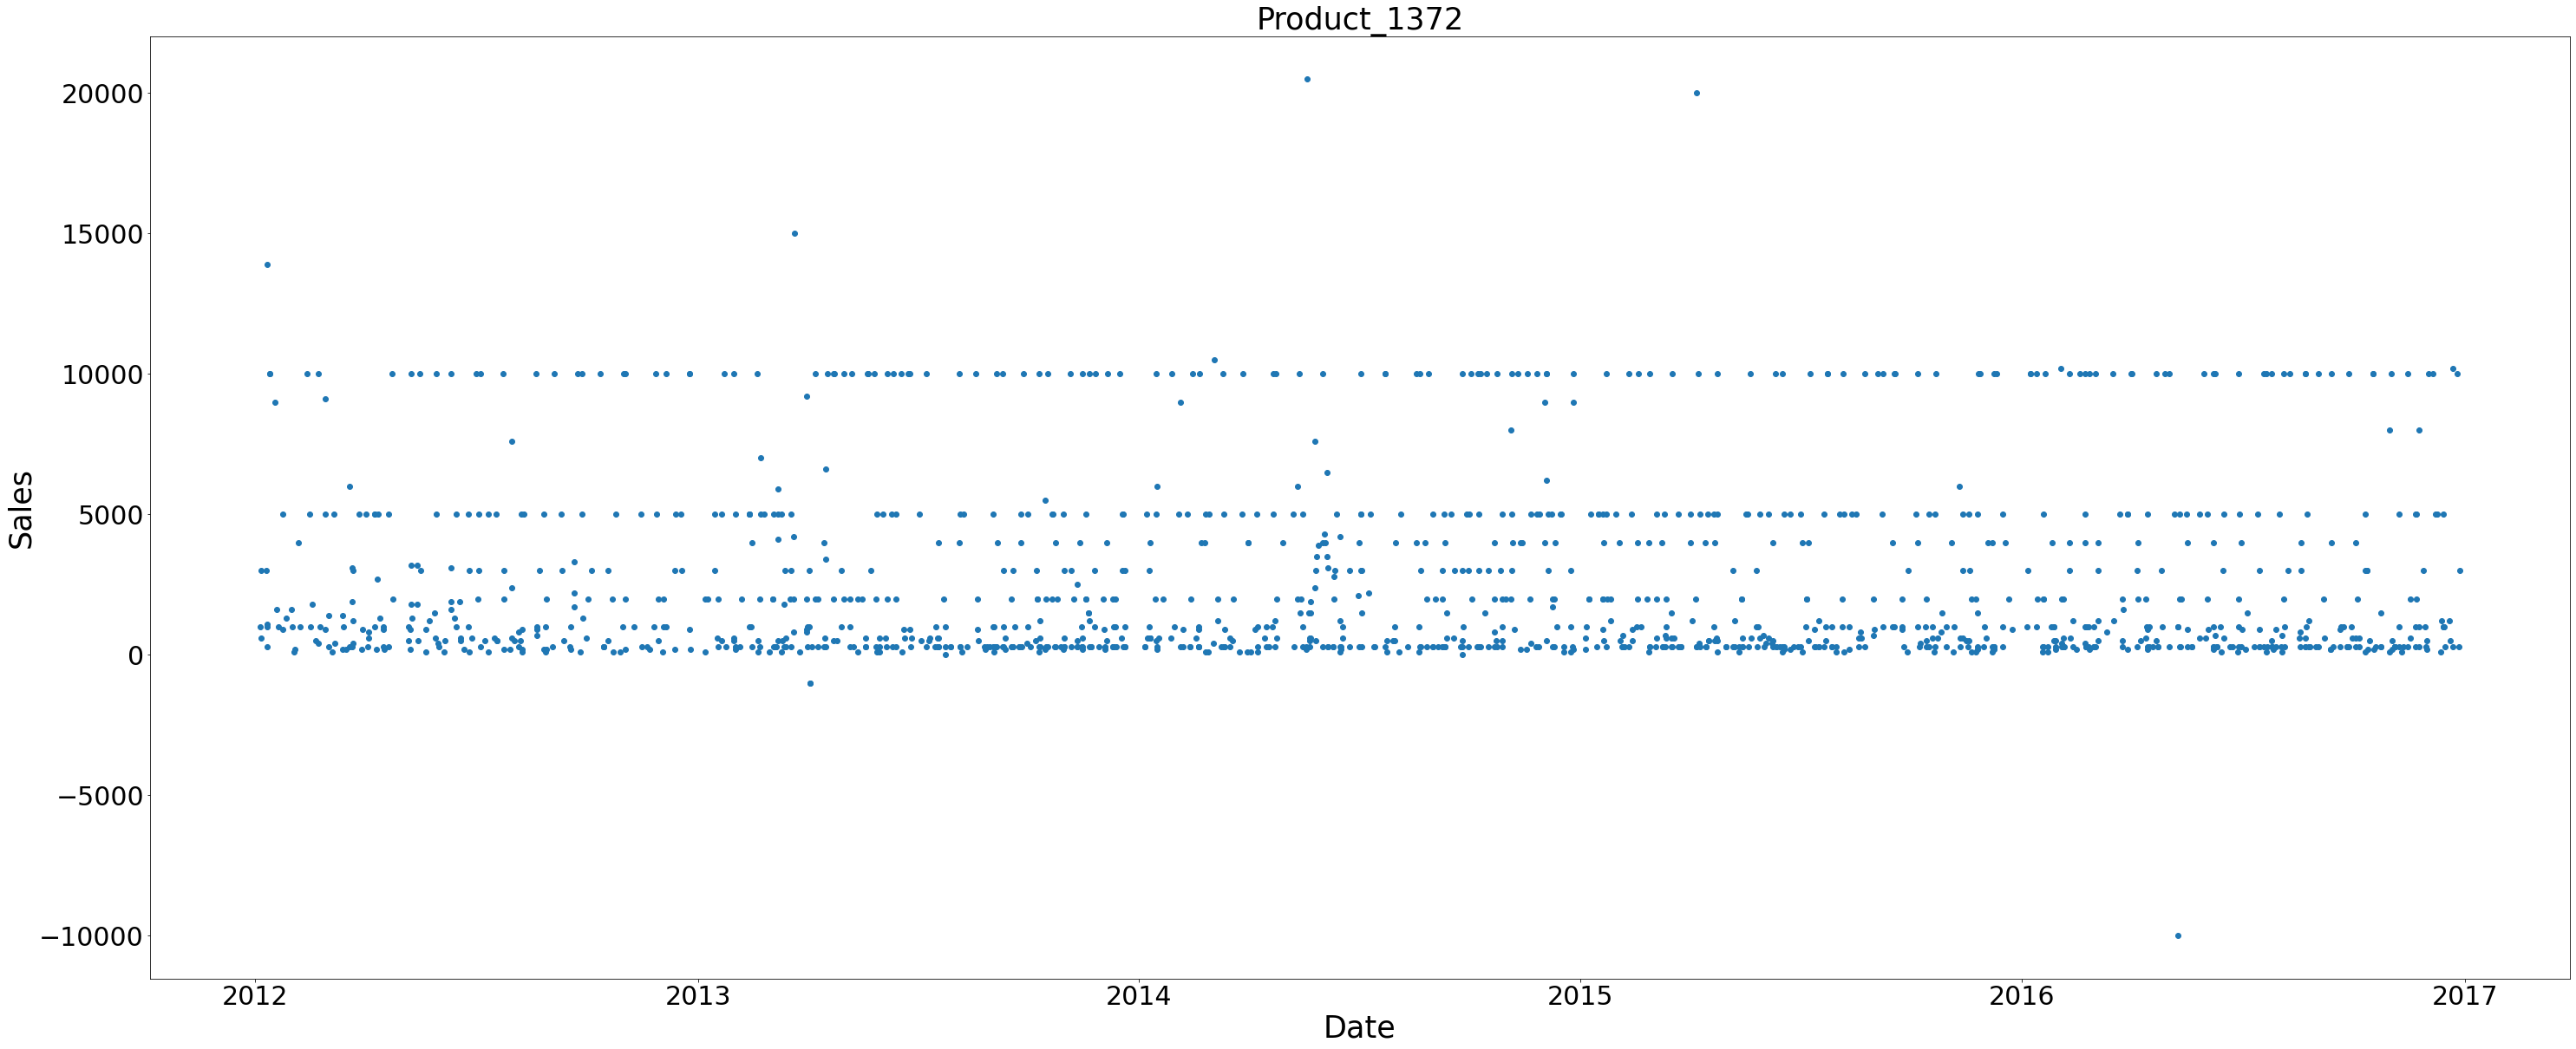

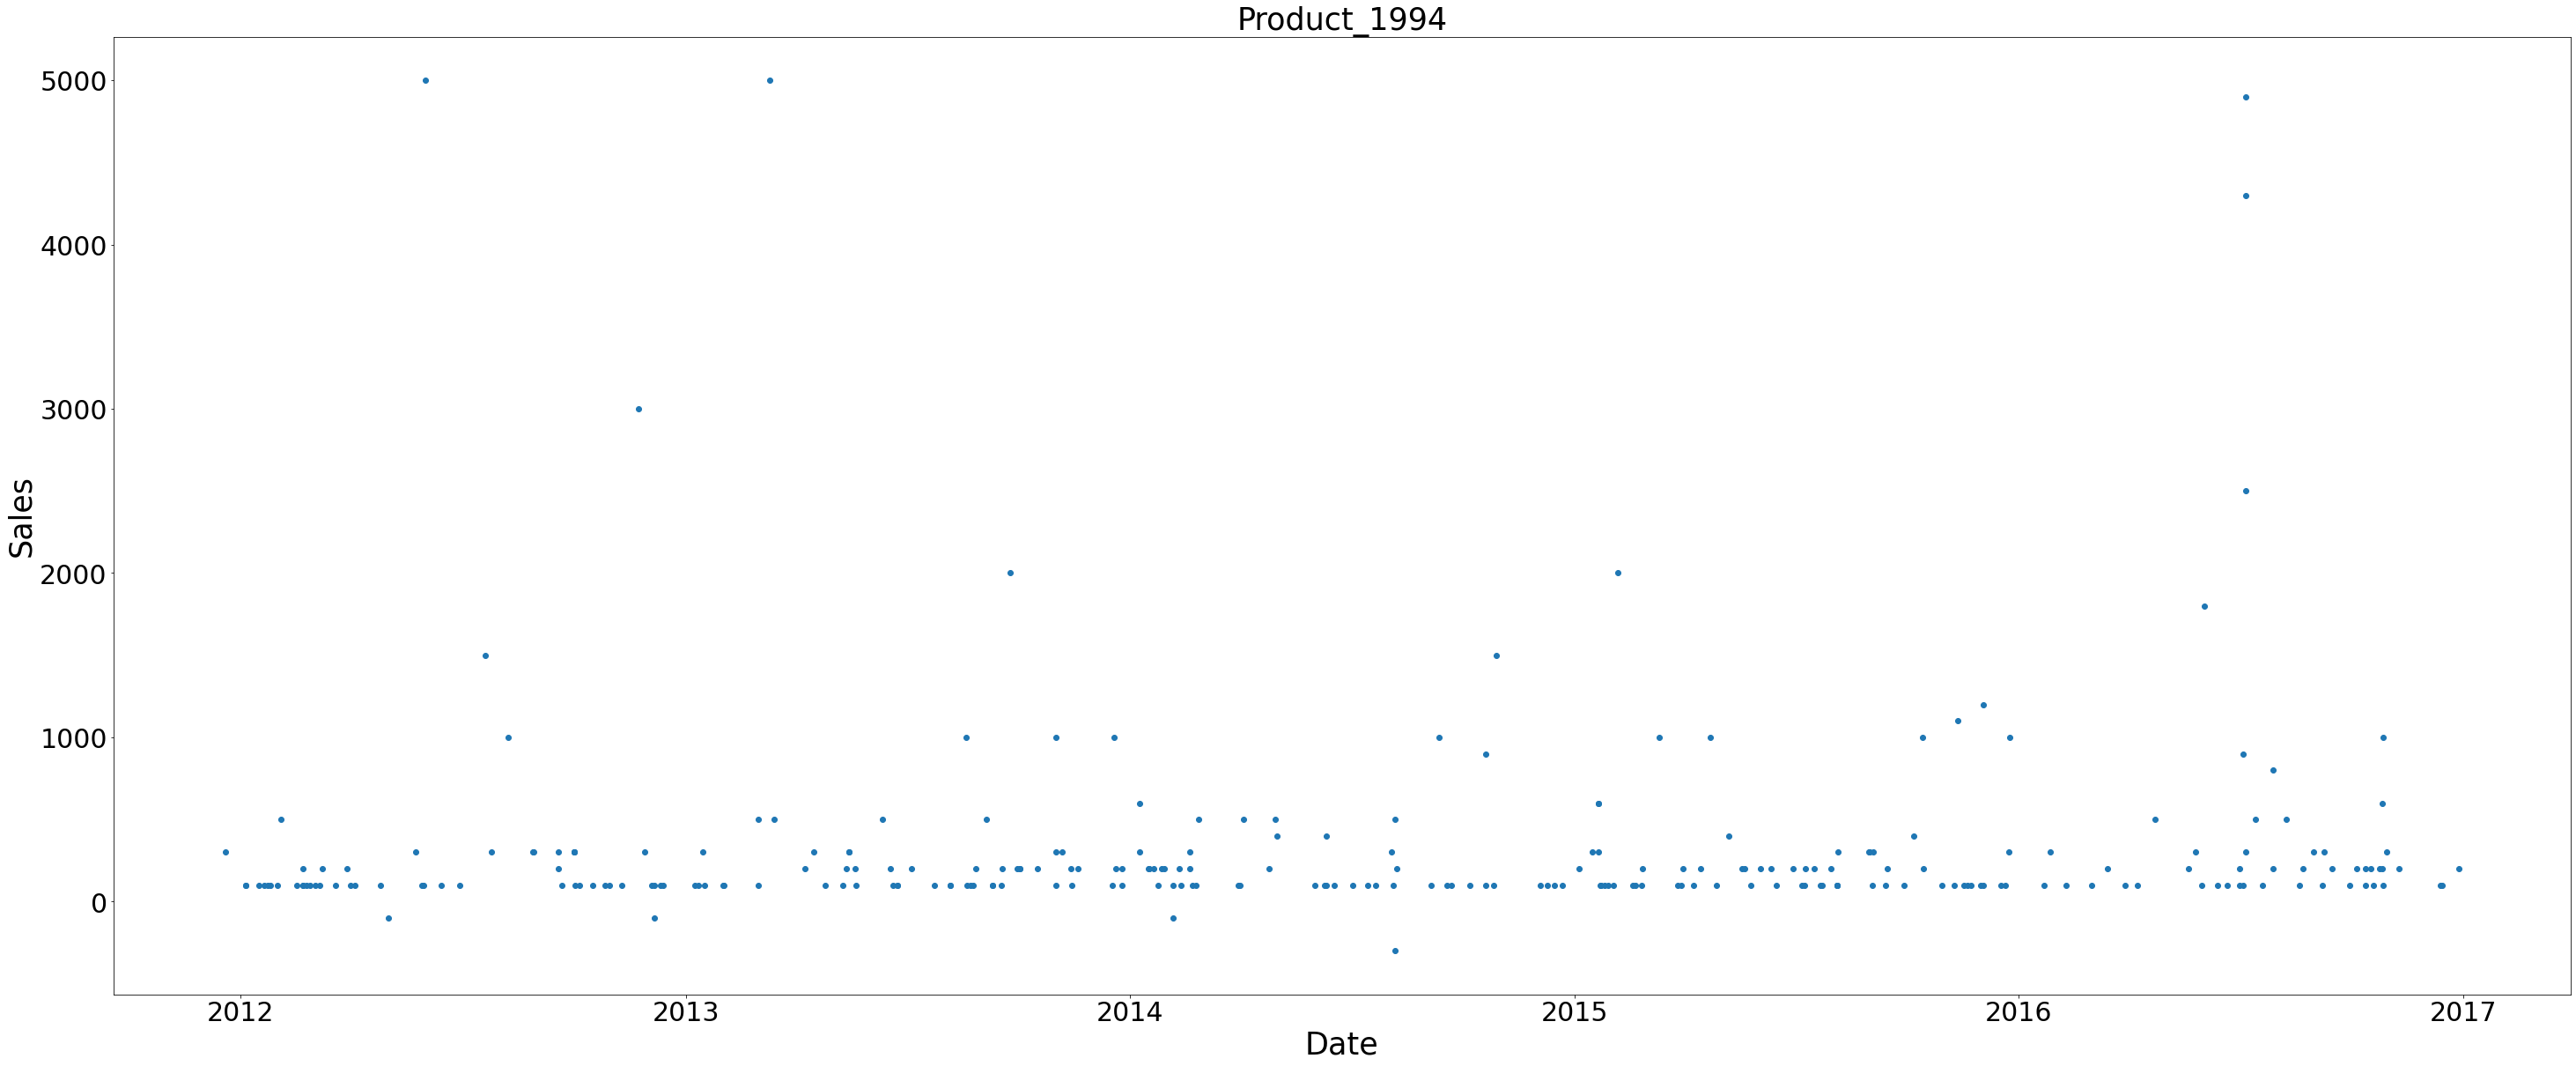

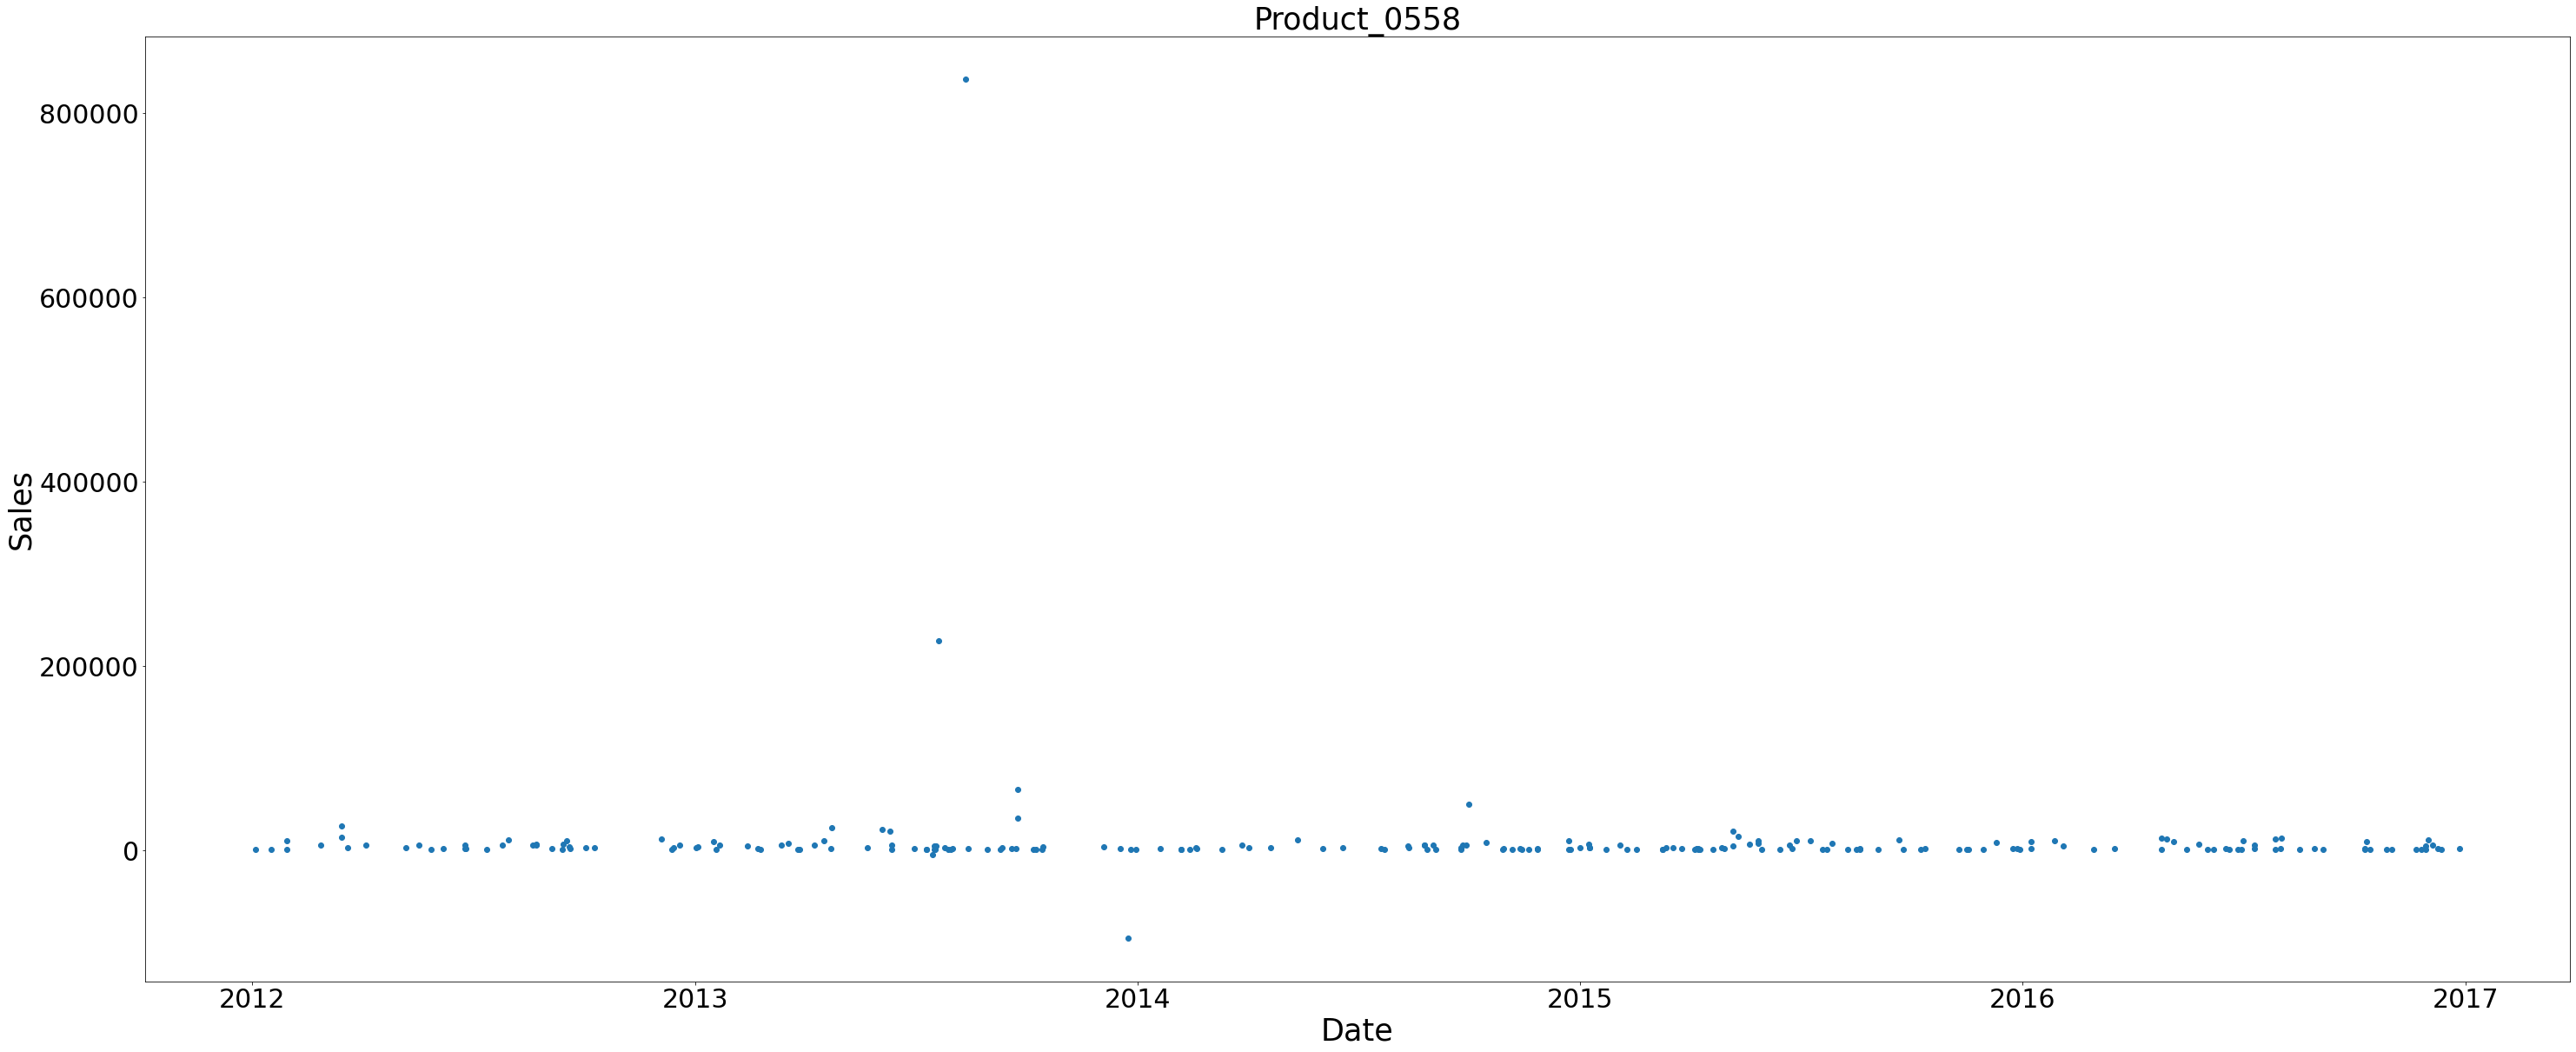

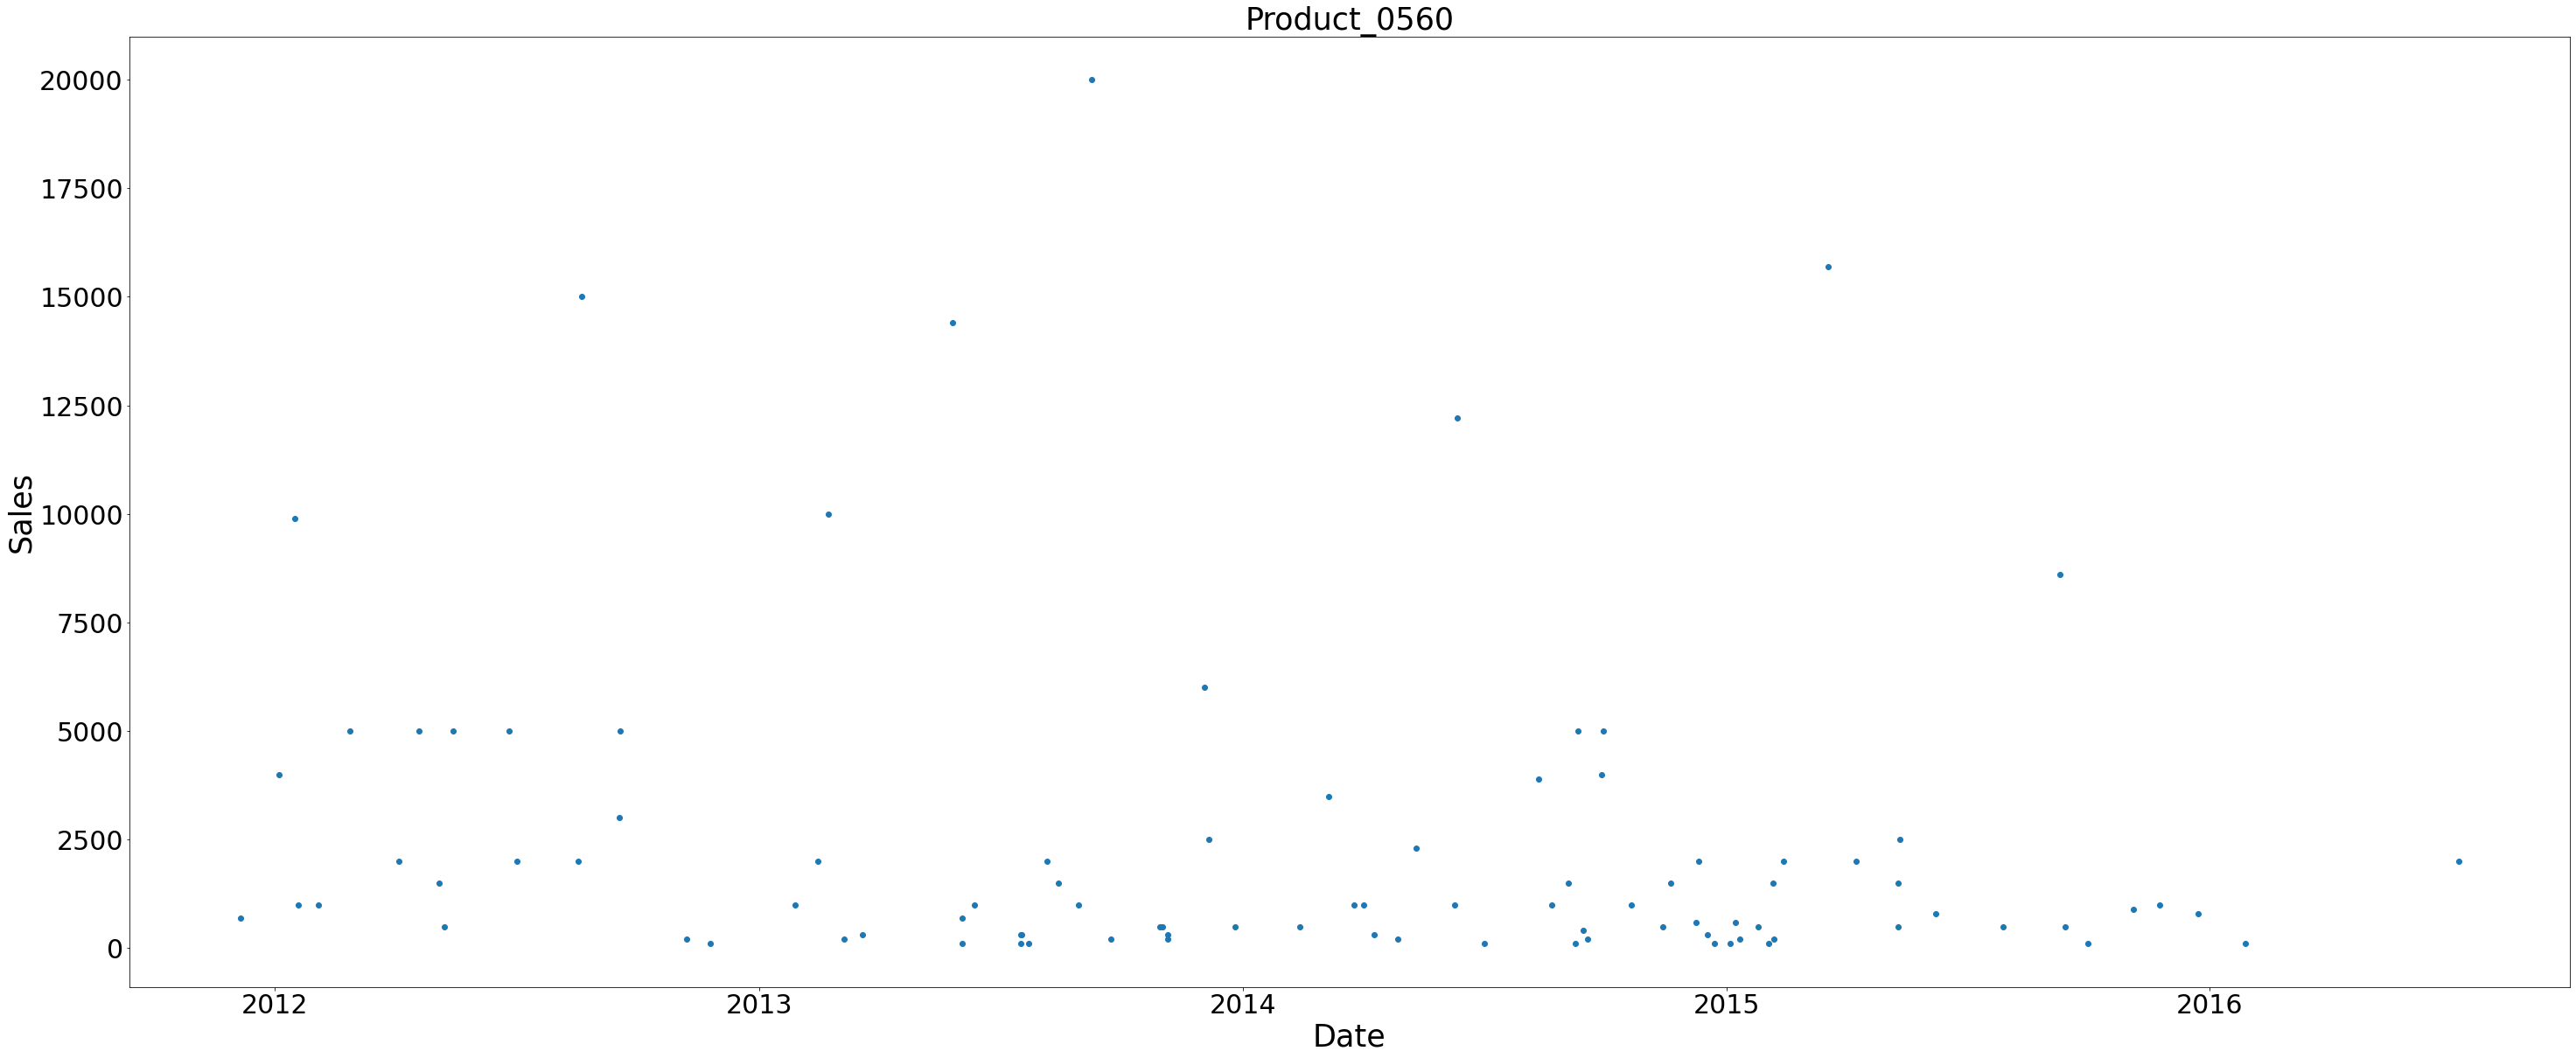

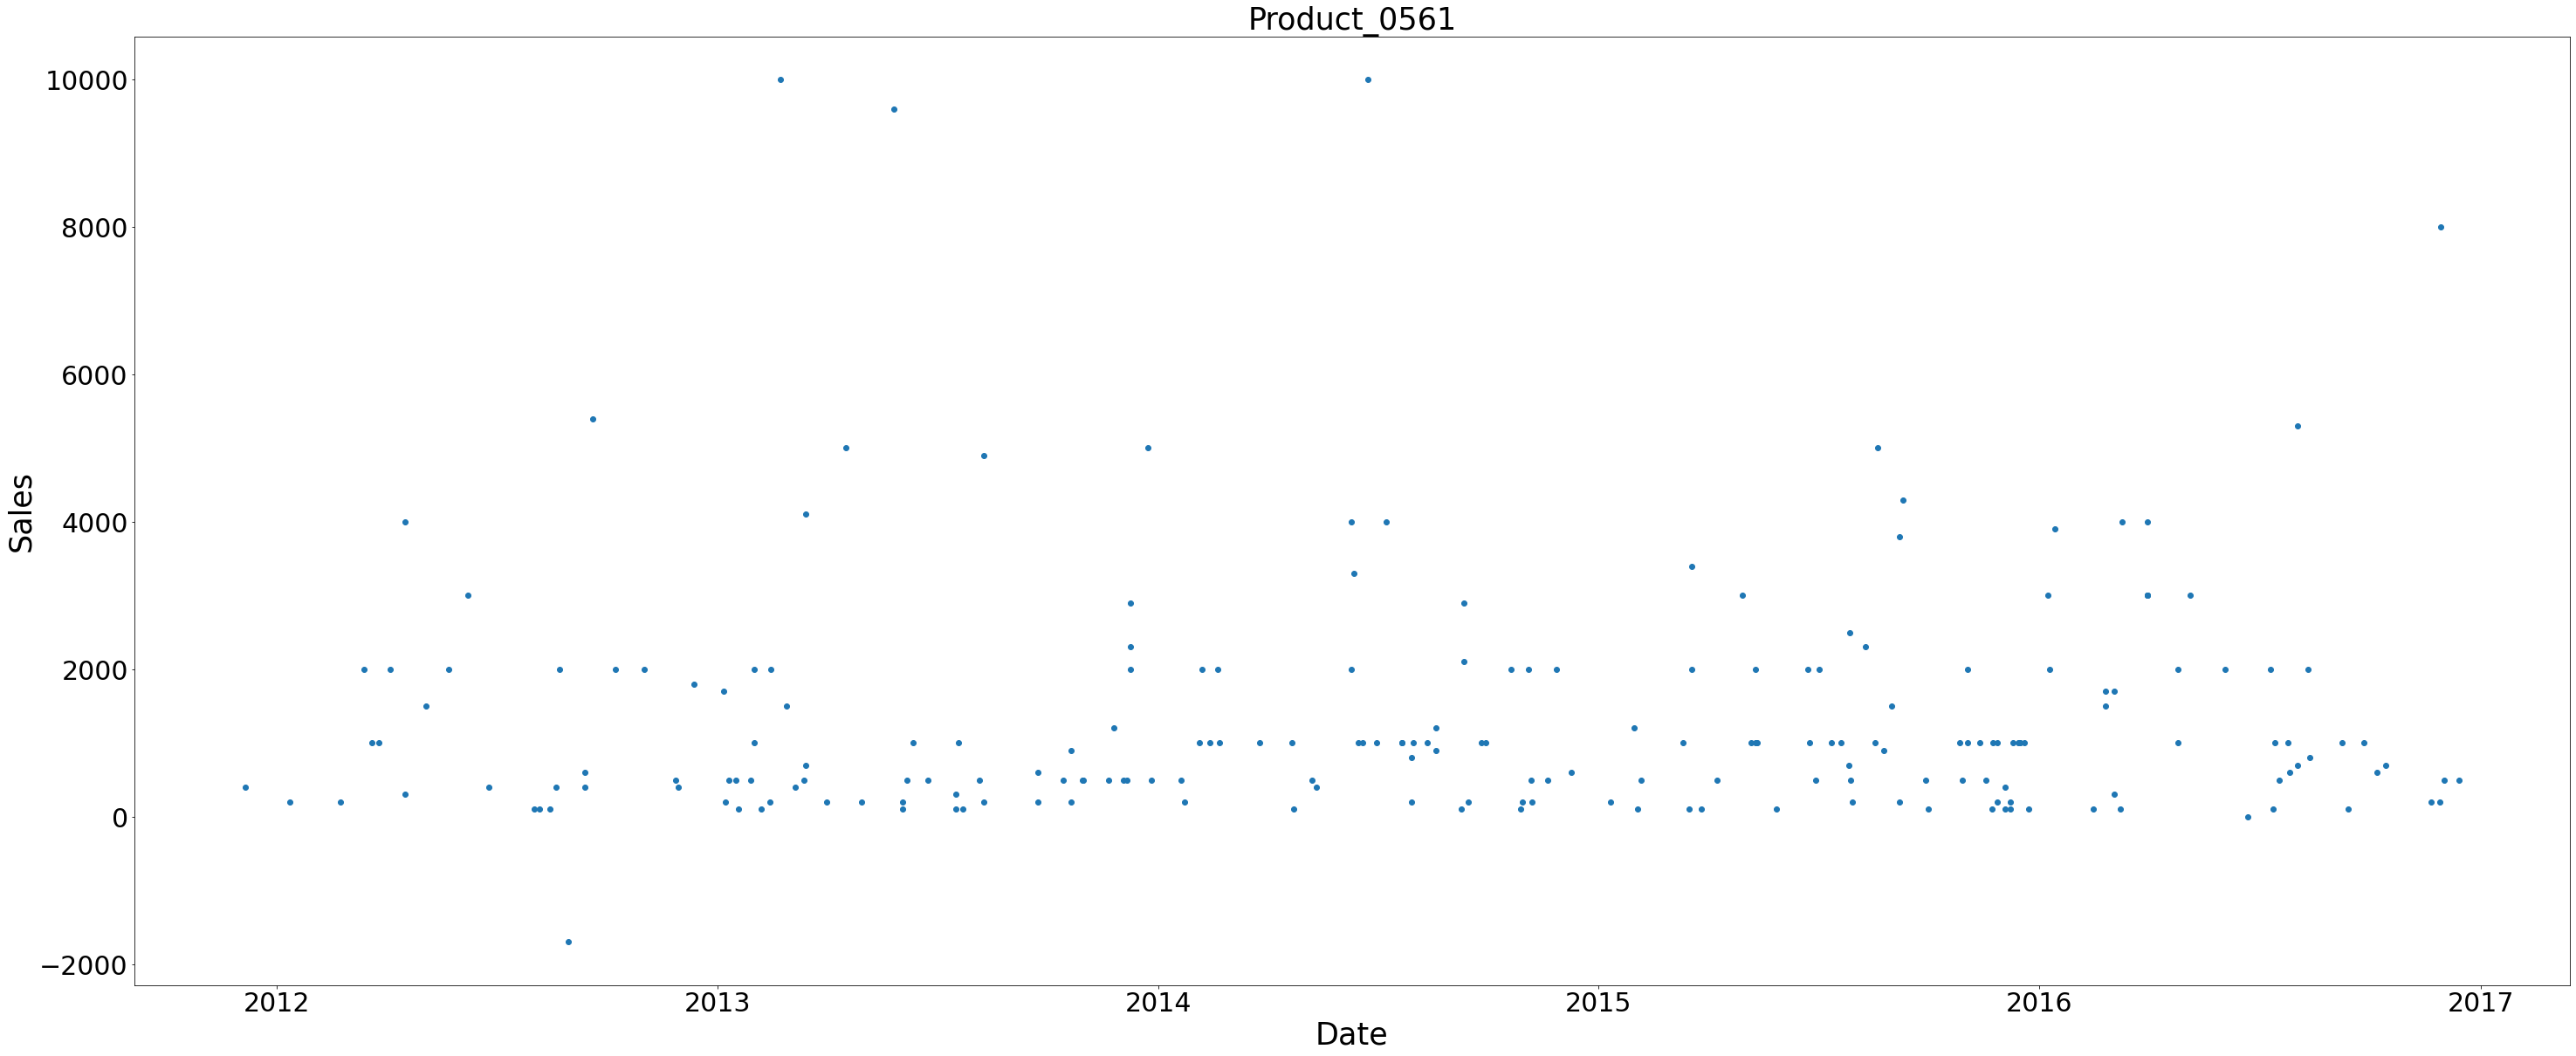

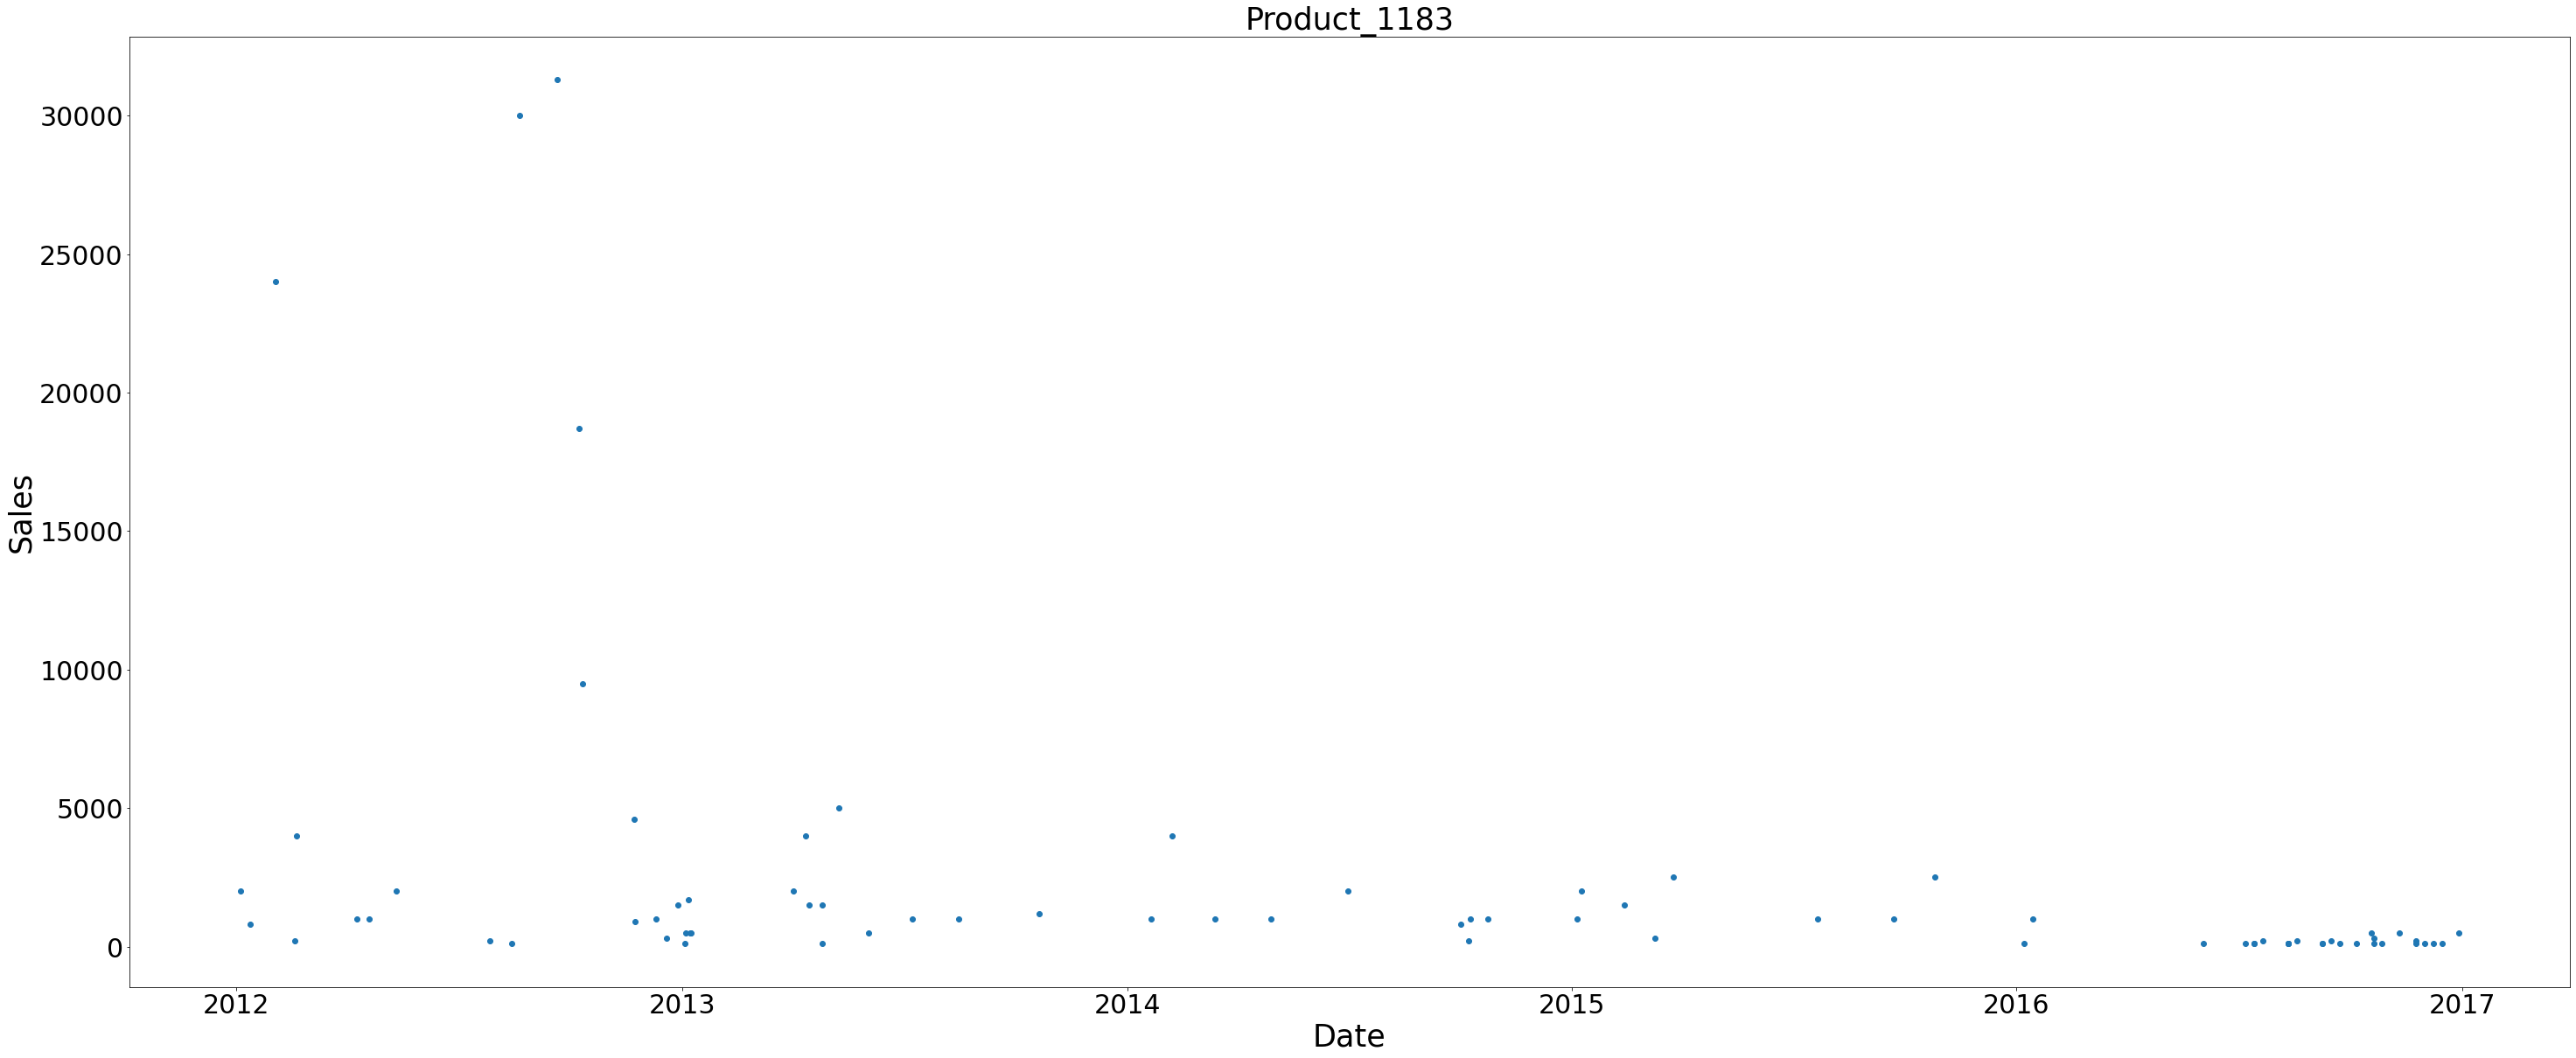

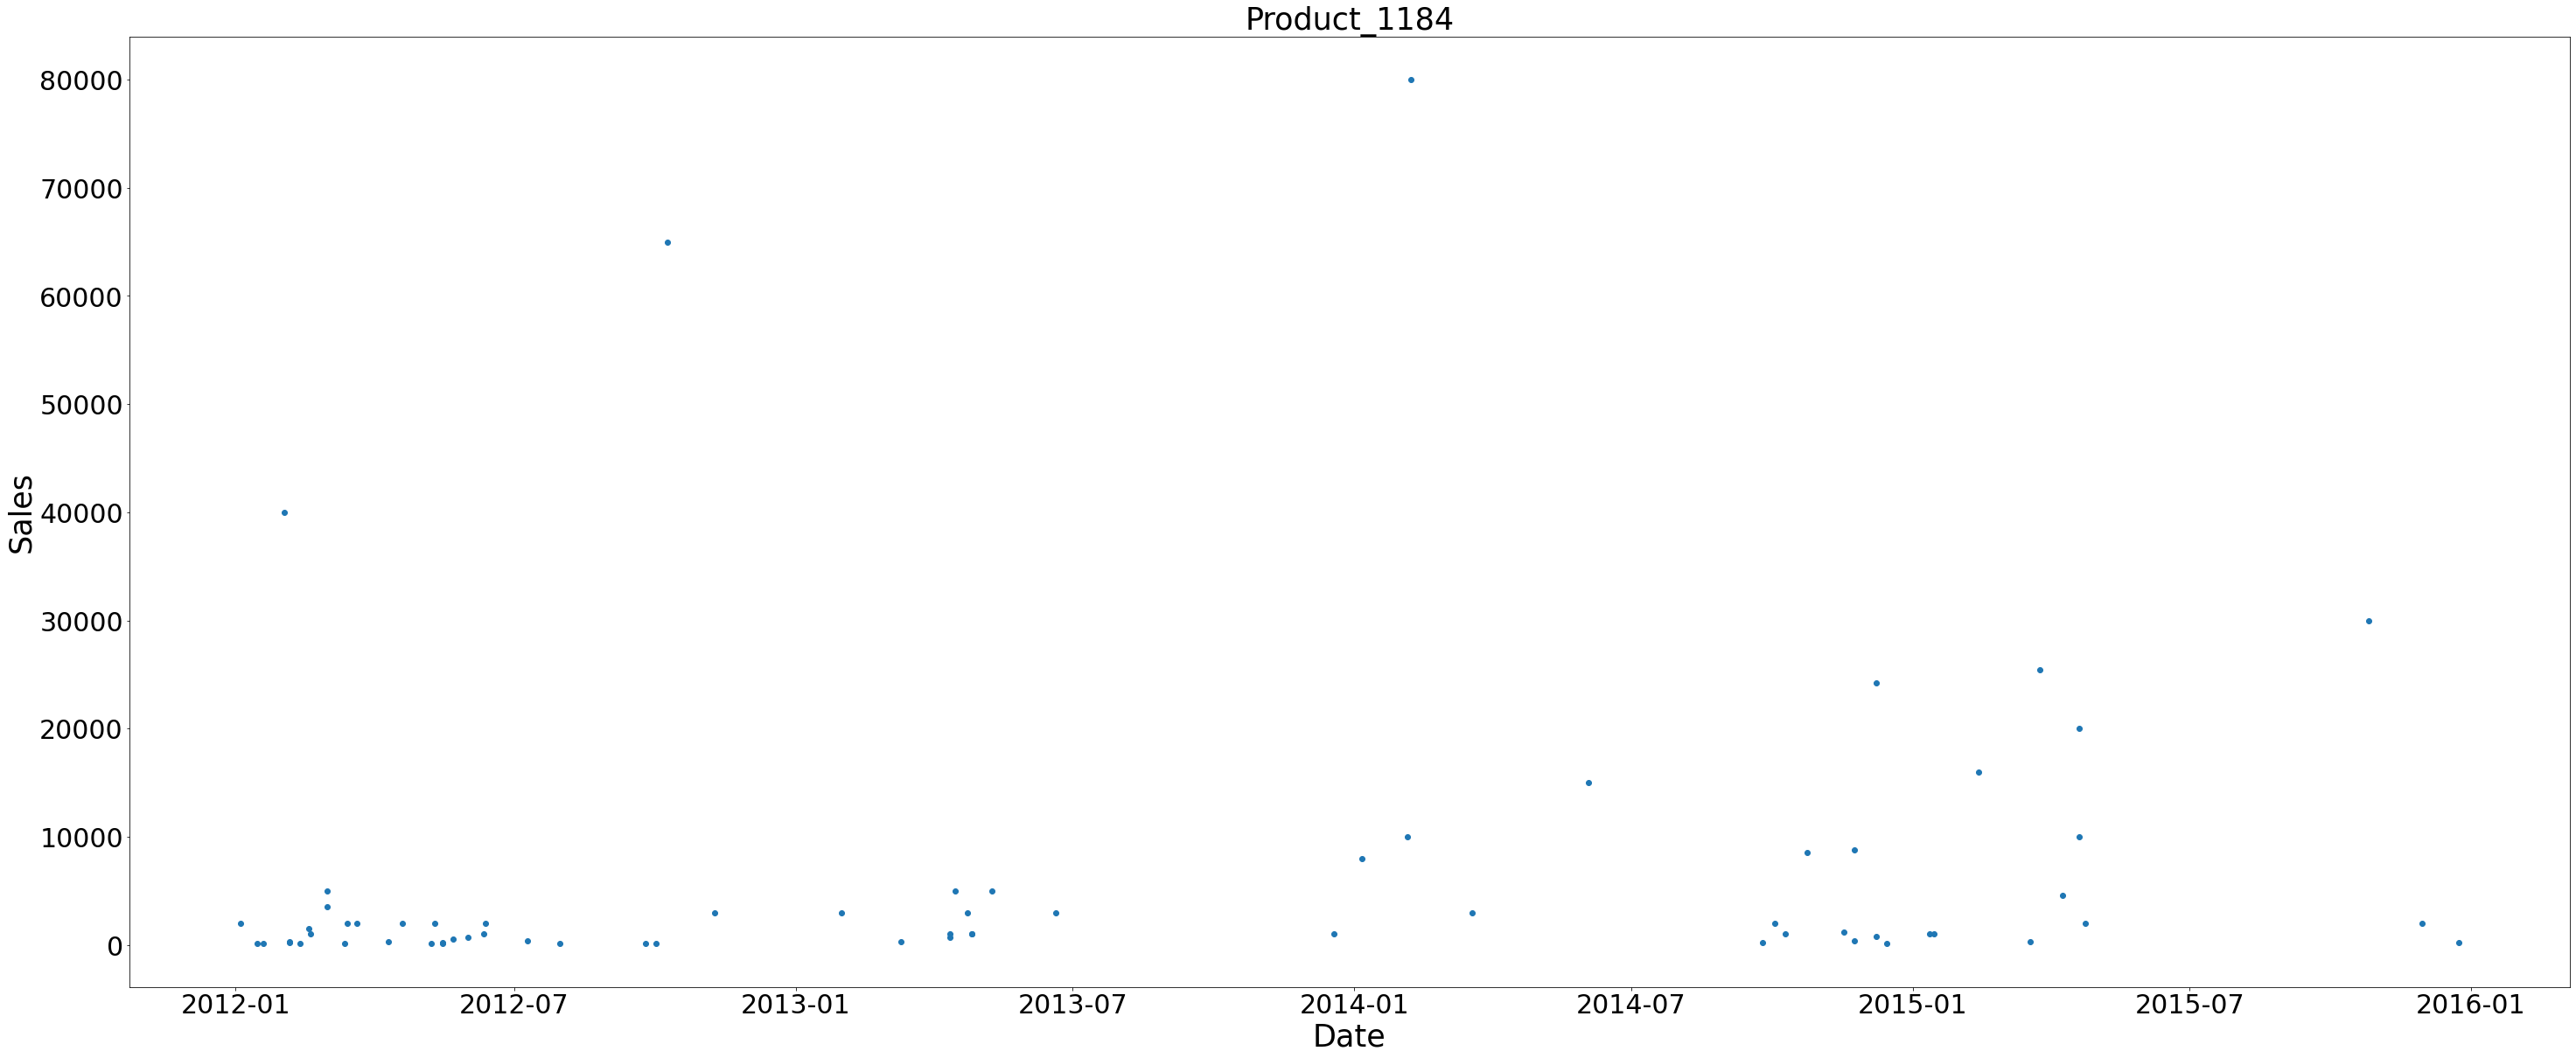

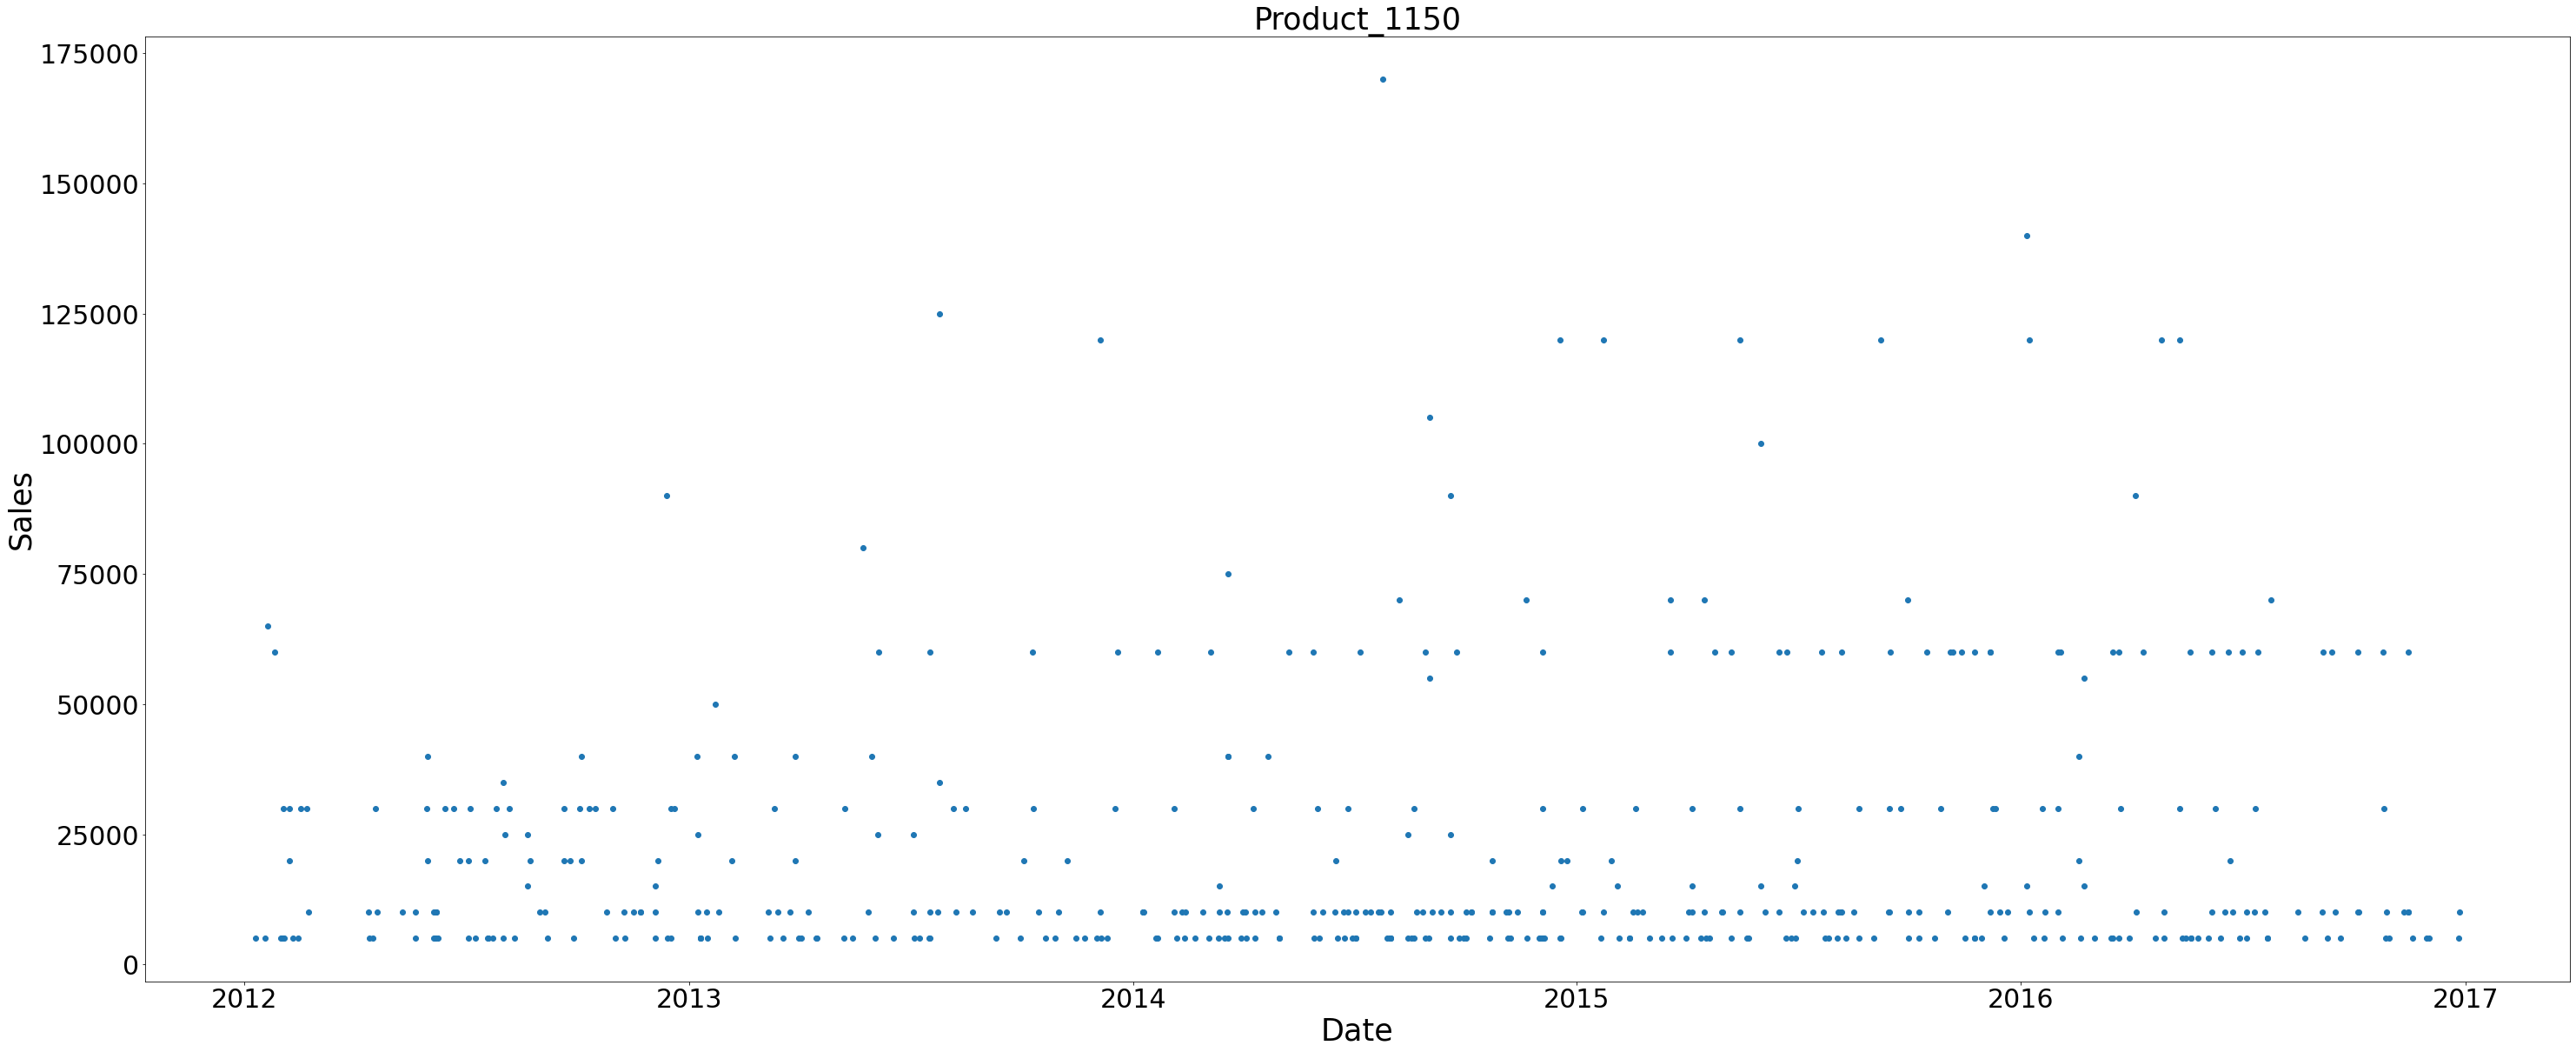

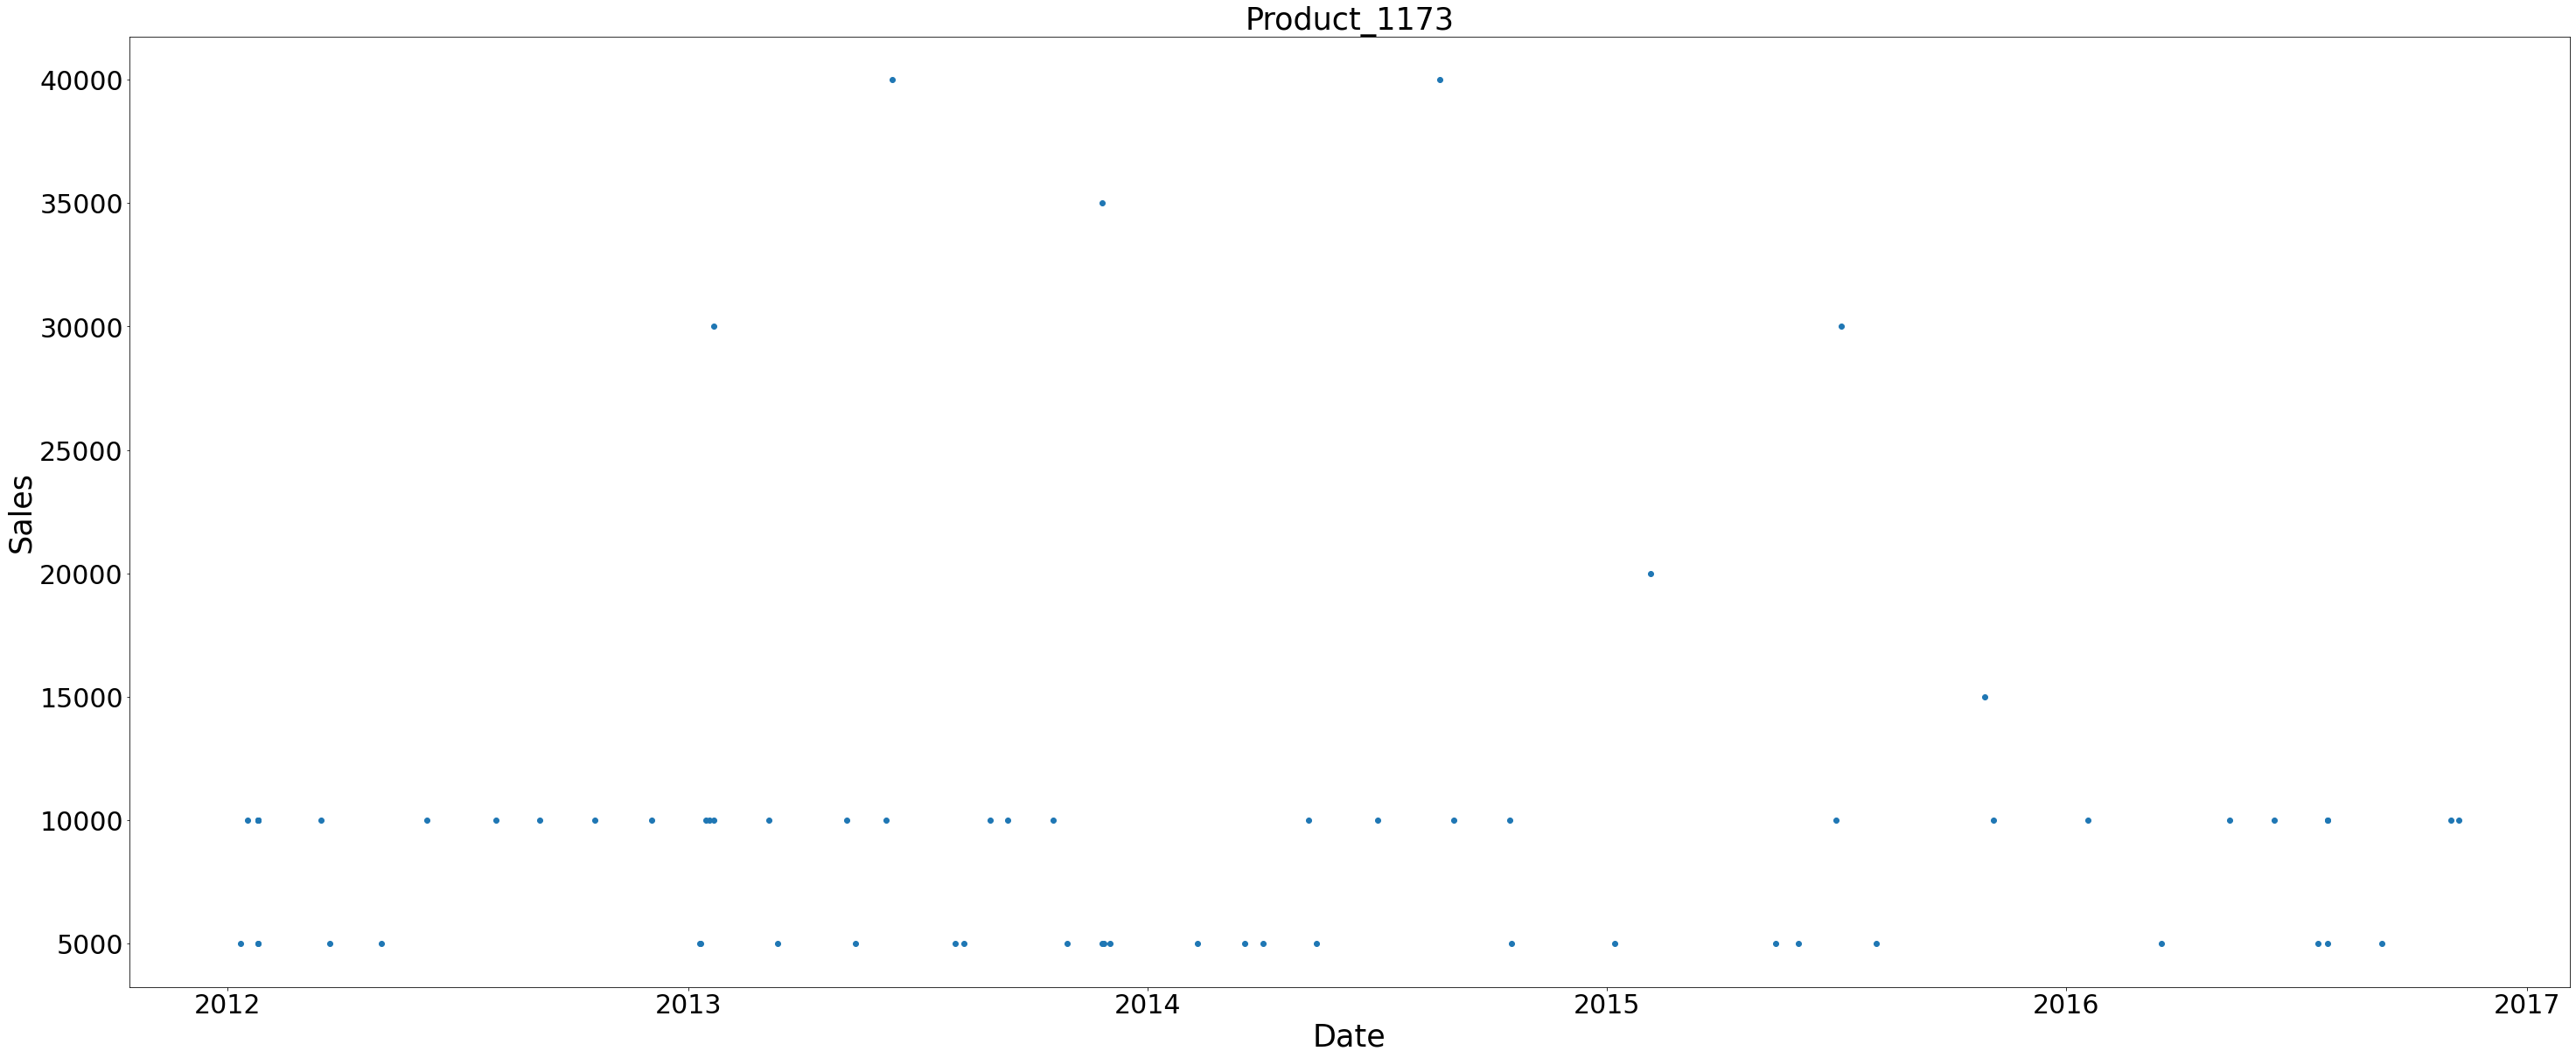

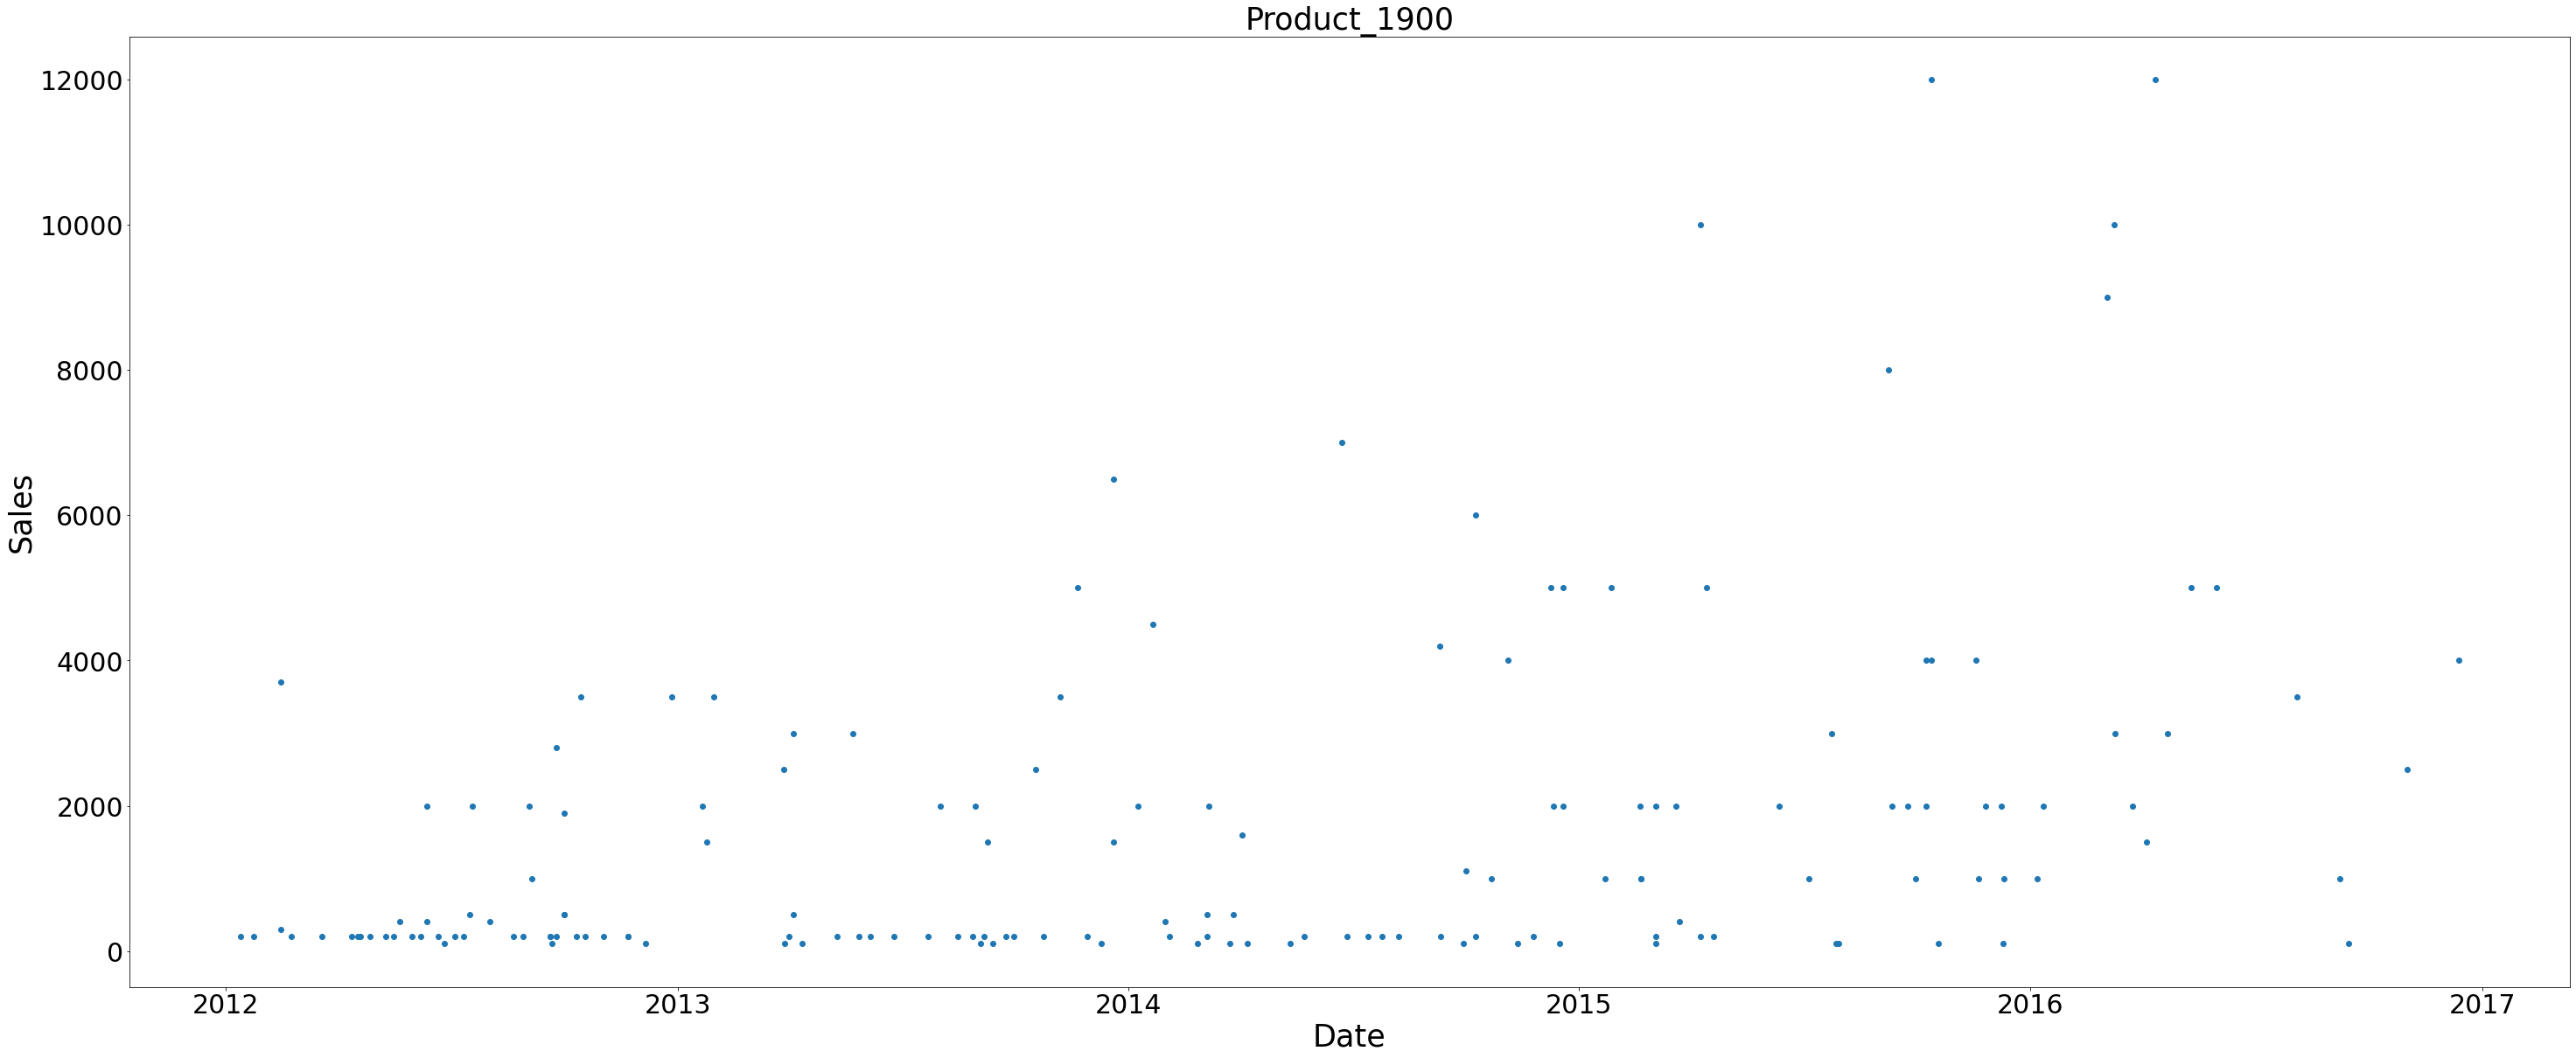

In [56]:
#Note: I had chosen the scatter plot for this information, since any attempt that I had with a line plot ended strangely, with certain points being connected to other points that were months away.
for product in small_list:
    product_rows = df[df['Product_Code'] == product]
    plt.figure(figsize = (50,20))
    plt.scatter(product_rows['Date'], product_rows['Order_Demand'])
    plt.xlabel('Date', fontsize=35)
    plt.ylabel('Sales', fontsize=35)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.title(product, fontsize=35)
    plt.show()

In [44]:
#Desired product trends: Product 1900, product 1150, product 0560, product 1512. 
df_1900 = main[main['Product_Code'] == 'Product_1900']
df_1900 = df_1900.drop(['Product_Code'], axis=1)

df_1150 = main[main['Product_Code'] == 'Product_1150']
df_1150 = df_1150.drop(['Product_Code'], axis=1)

df_0560 = main[main['Product_Code'] == 'Product_0560']
df_0560 = df_0560.drop(['Product_Code'], axis=1)

df_1512 = main[main['Product_Code'] == 'Product_1512']
df_1512 = df_1512.drop(['Product_Code'], axis=1)

In [46]:
df_1900
# df_1900.dtypes


,Date,Order_Demand
267,2012-01-24,200
271,2012-02-23,200
273,2012-04-12,200
274,2012-04-17,200
278,2012-04-19,200
...,...,...
1001112,2016-04-21,3000
1001116,2016-08-04,3500
1001117,2016-09-08,1000
1001118,2016-11-01,2500


Now that the data has been collected and cleaned for four products, each product will undergo a decomposition analysis.

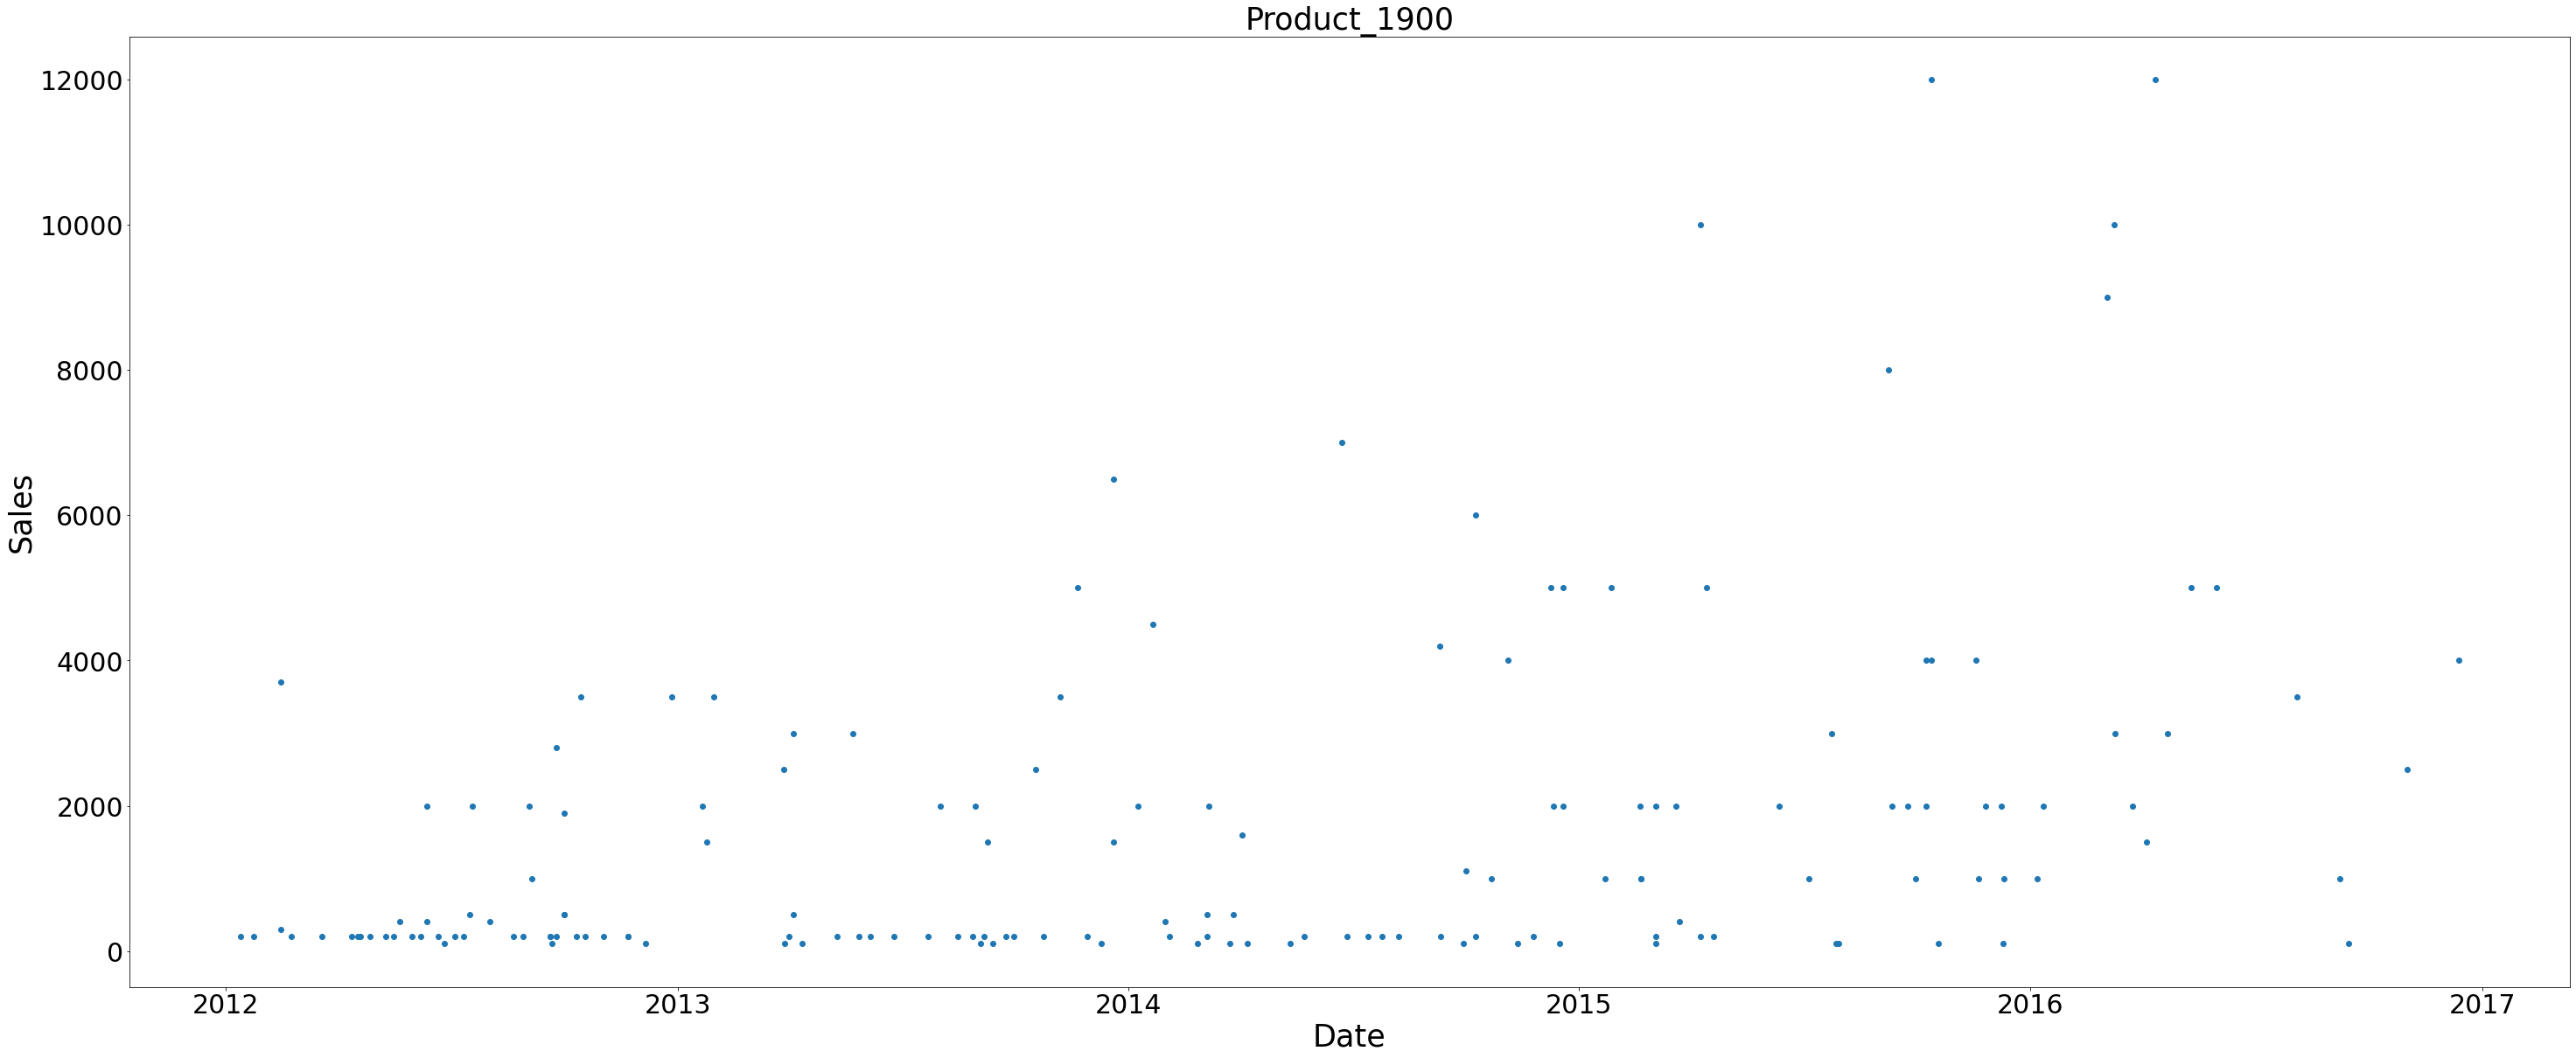

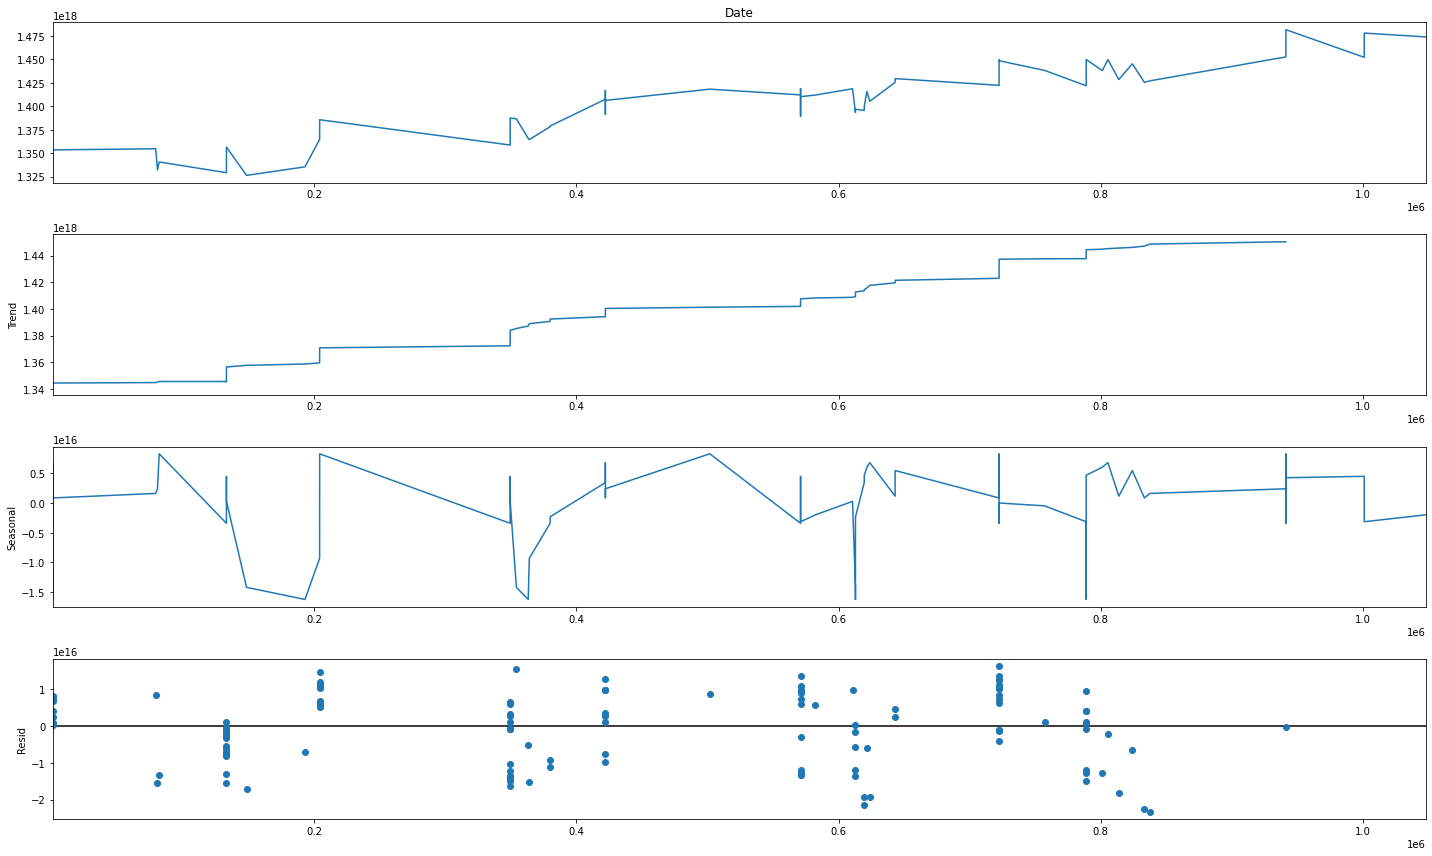

In [78]:
#Used a frequency of 30 to 
plt.figure(figsize = (50,20))
plt.scatter(df_1900['Date'], df_1900['Order_Demand'])
plt.xlabel('Date', fontsize=35)
plt.ylabel('Sales', fontsize=35)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.title('Product_1900', fontsize=35)
plt.show()
decomp_1900 = seasonal_decompose(df_1900['Date'], model='additive', period=30)
decomp_1900.plot()
mpl.rcParams['figure.figsize'] = (20, 12)
plt.show()

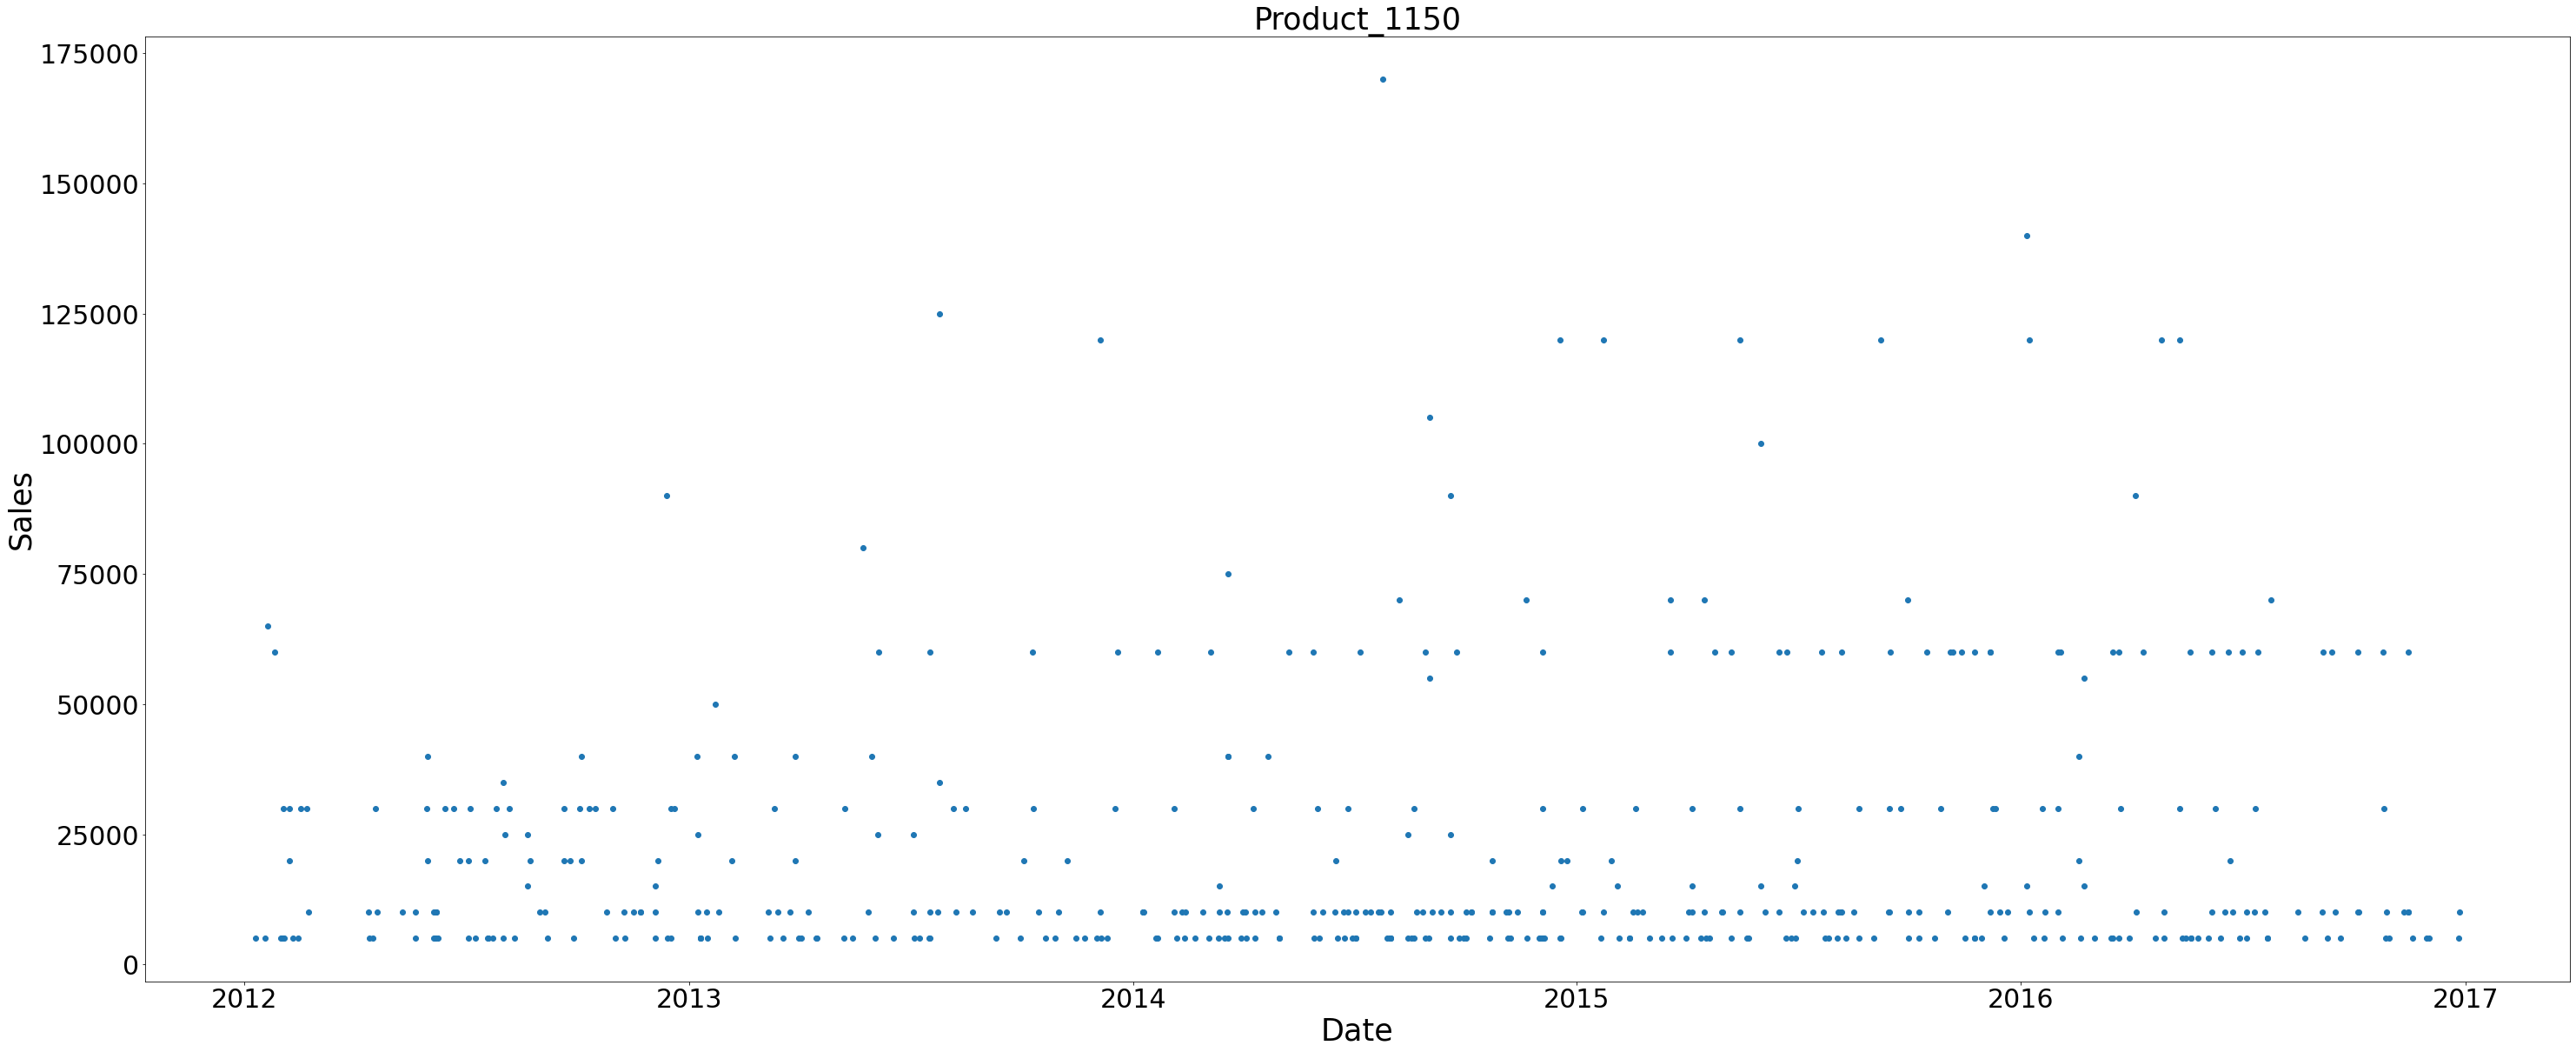

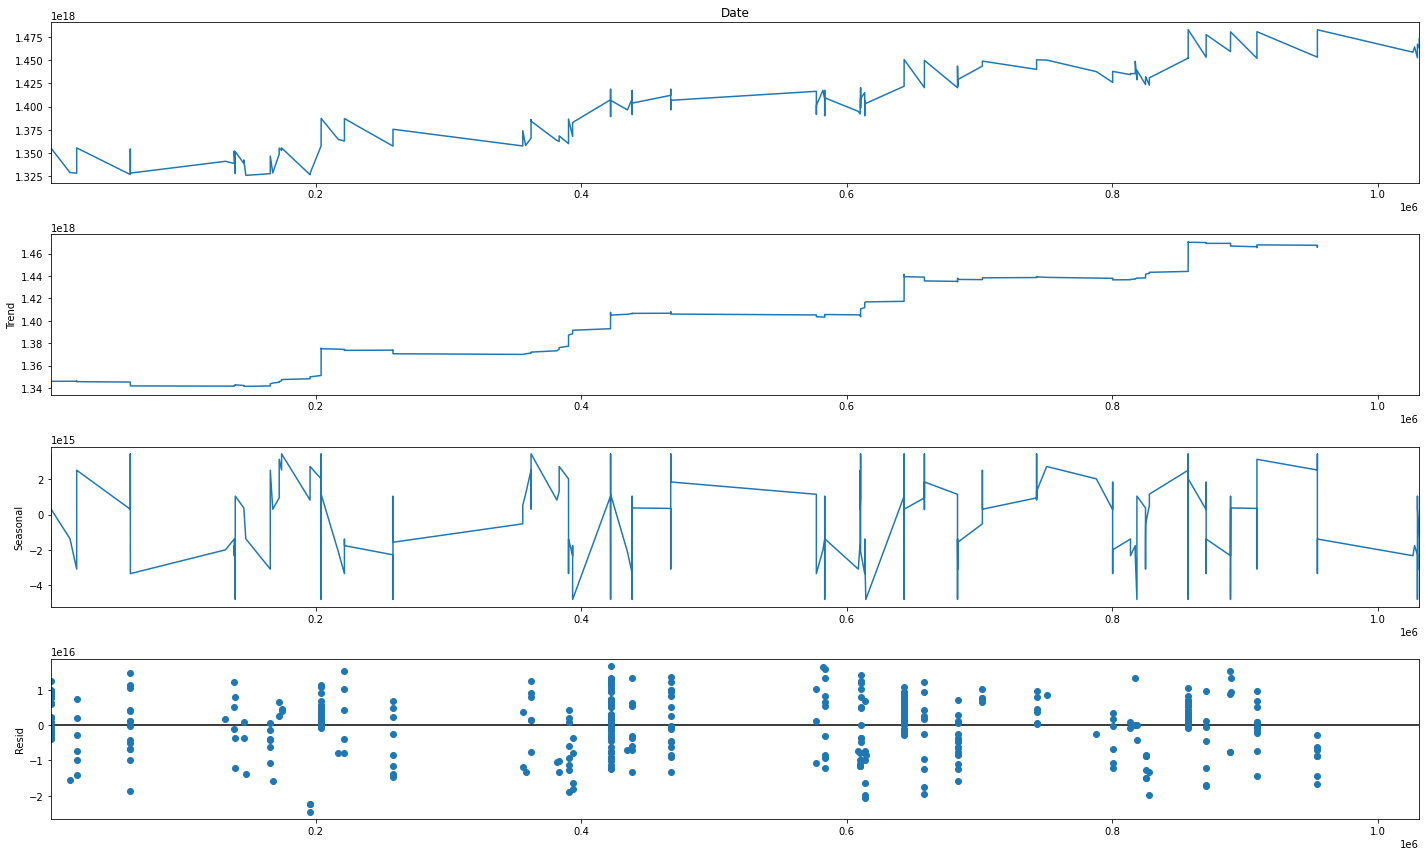

In [79]:
plt.figure(figsize = (50,20))
plt.scatter(df_1150['Date'], df_1150['Order_Demand'])
plt.xlabel('Date', fontsize=35)
plt.ylabel('Sales', fontsize=35)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.title('Product_1150', fontsize=35)
plt.show()
decomp_1150 = seasonal_decompose(df_1150['Date'], model='additive', period=30)
decomp_1150.plot()
mpl.rcParams['figure.figsize'] = (20, 12)
plt.show()

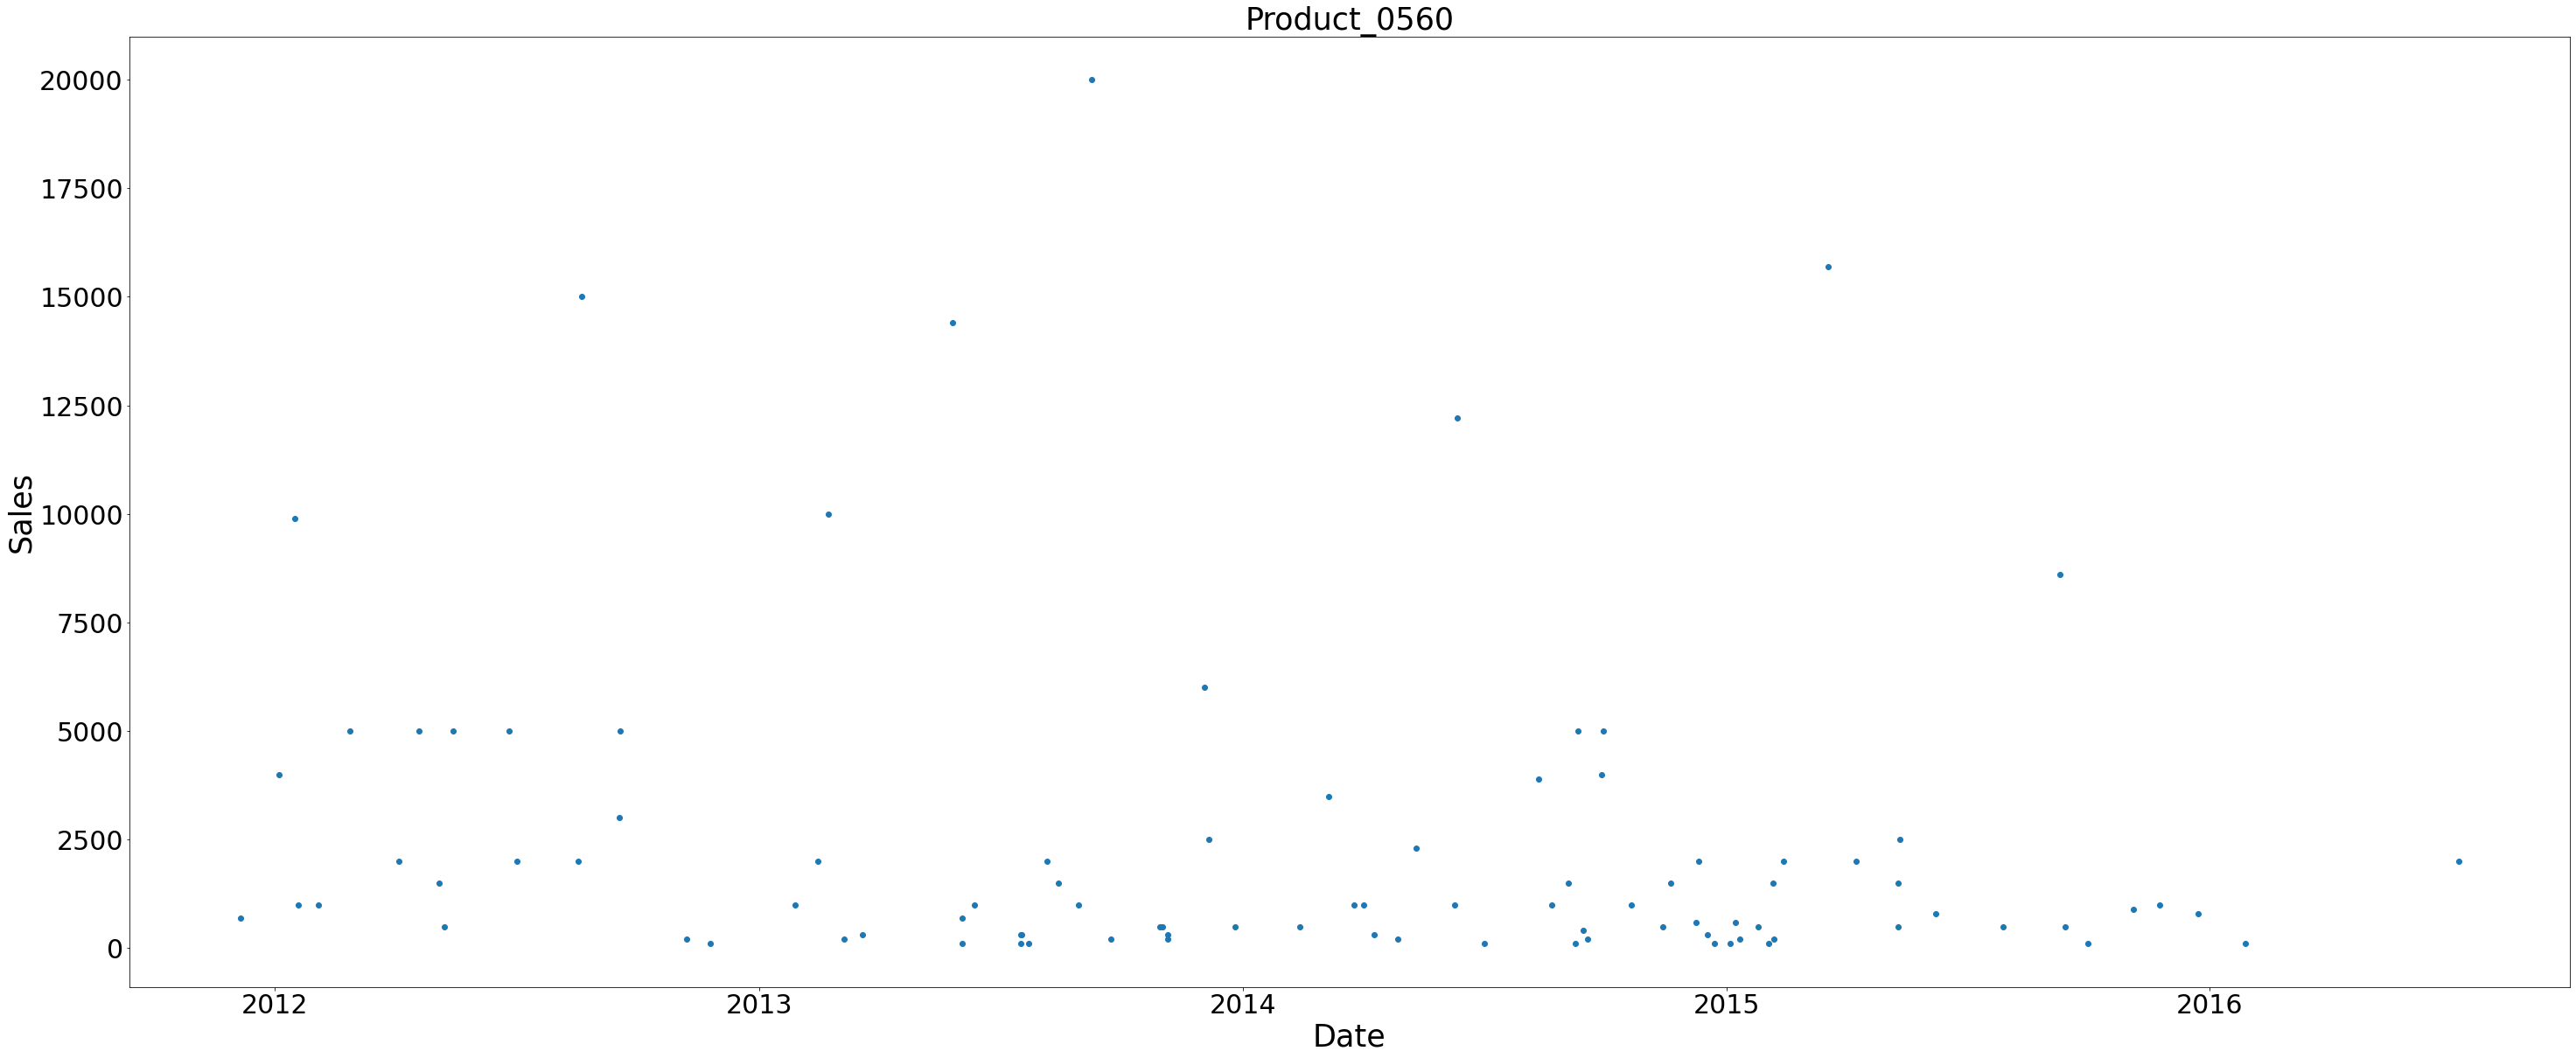

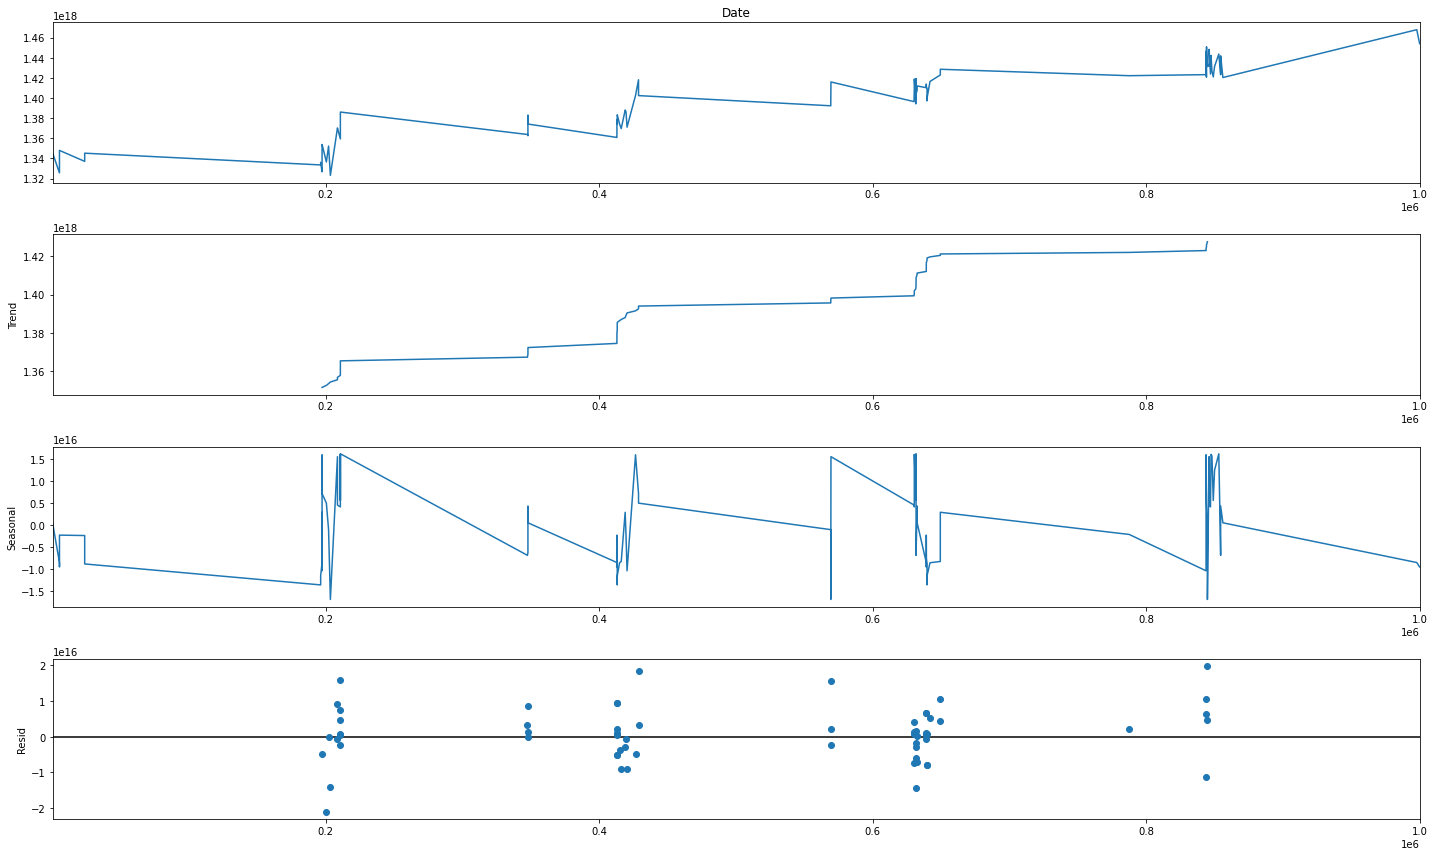

In [80]:
plt.figure(figsize = (50,20))
plt.scatter(df_0560['Date'], df_0560['Order_Demand'])
plt.xlabel('Date', fontsize=35)
plt.ylabel('Sales', fontsize=35)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.title('Product_0560', fontsize=35)
plt.show()
decomp_0560 = seasonal_decompose(df_0560['Date'], model='additive', period=30)
decomp_0560.plot()
mpl.rcParams['figure.figsize'] = (20, 12)
plt.show()

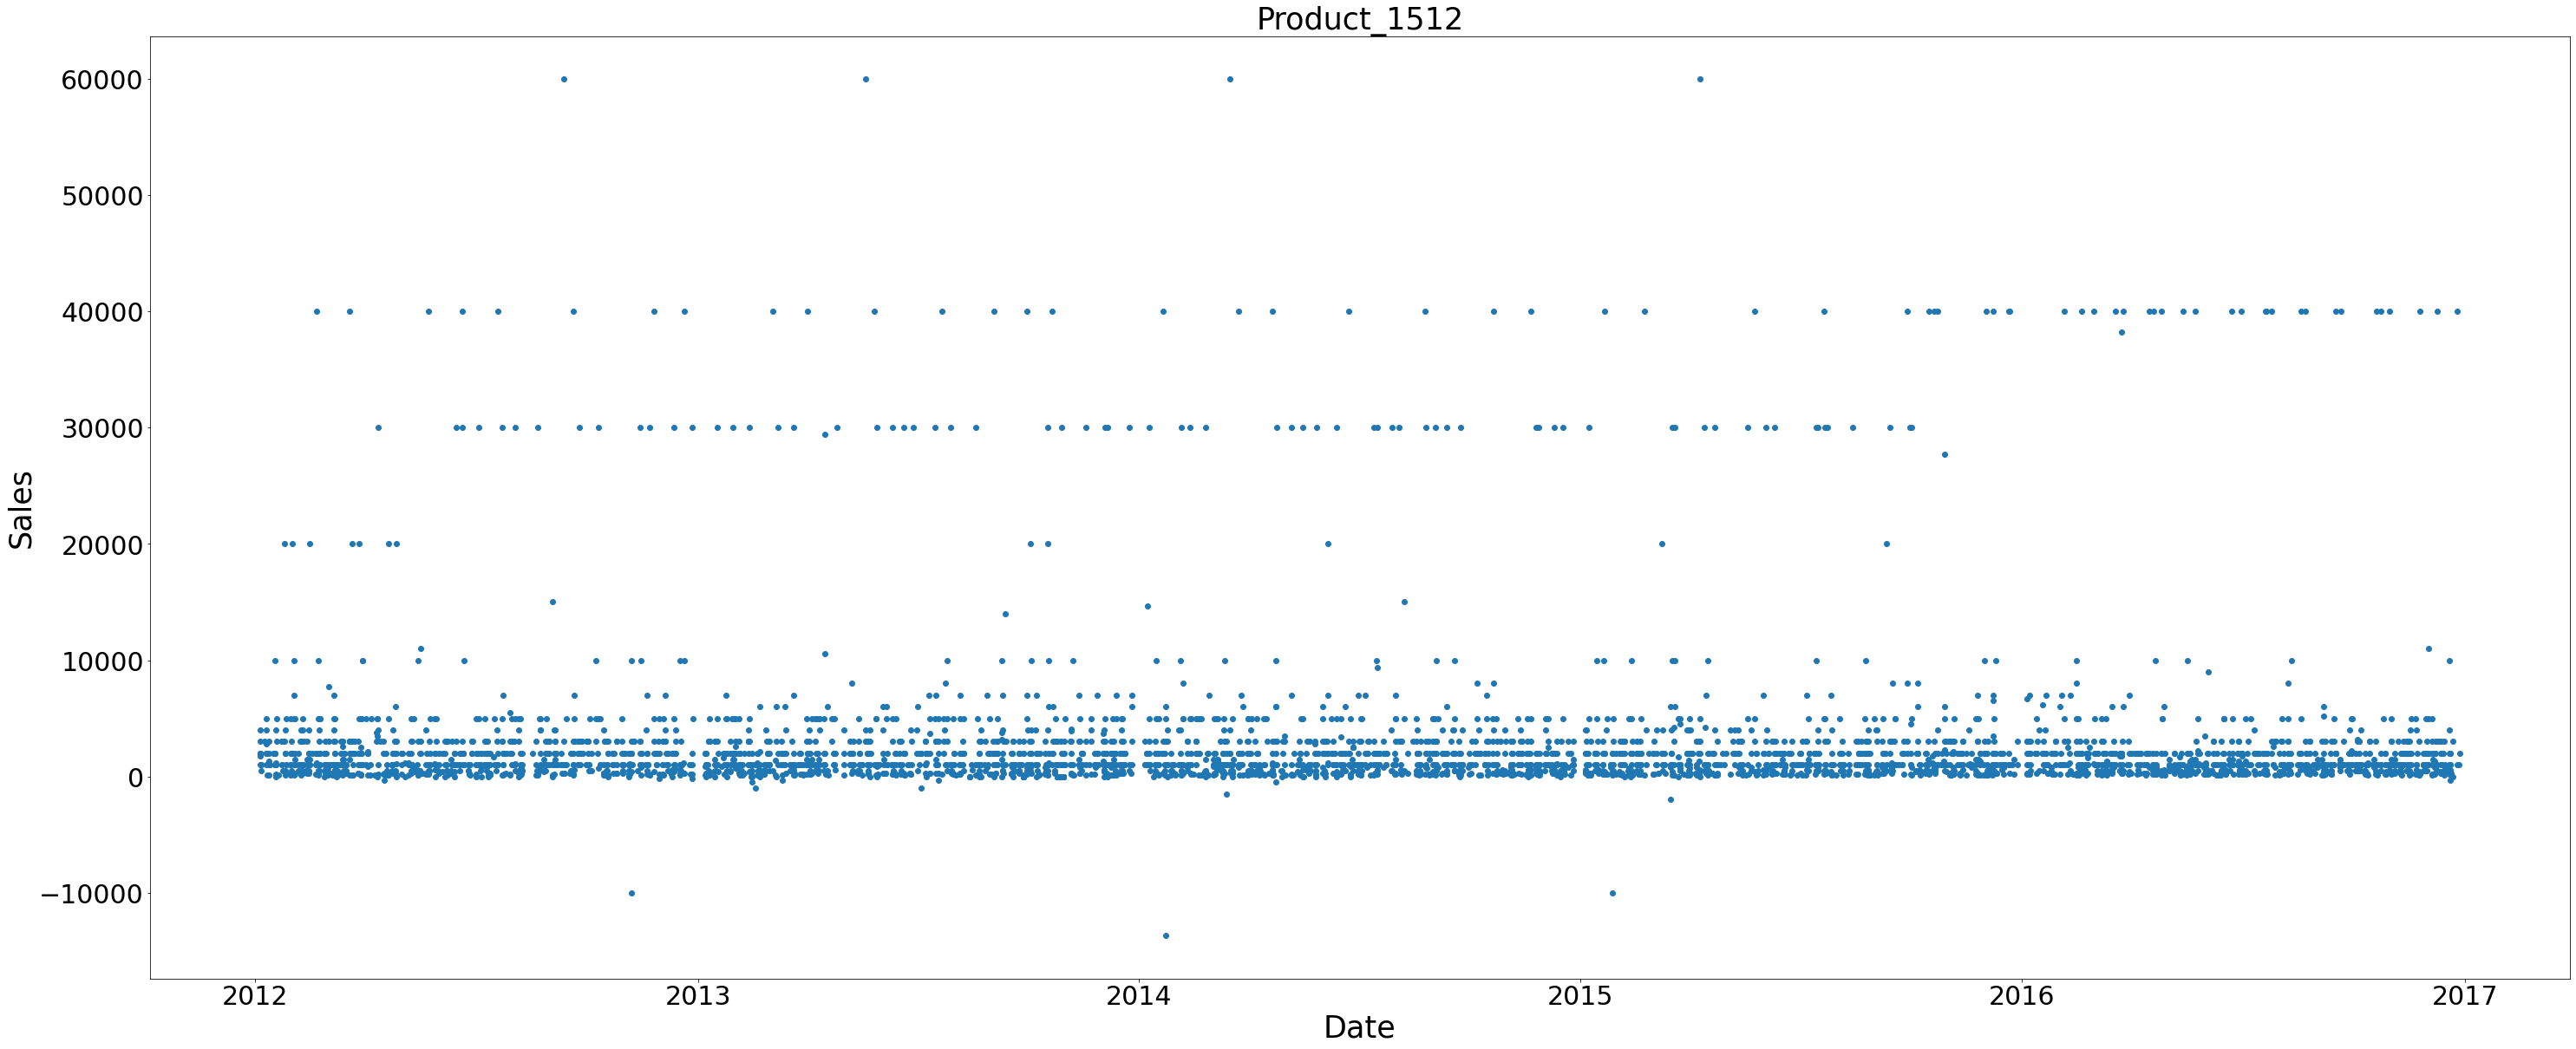

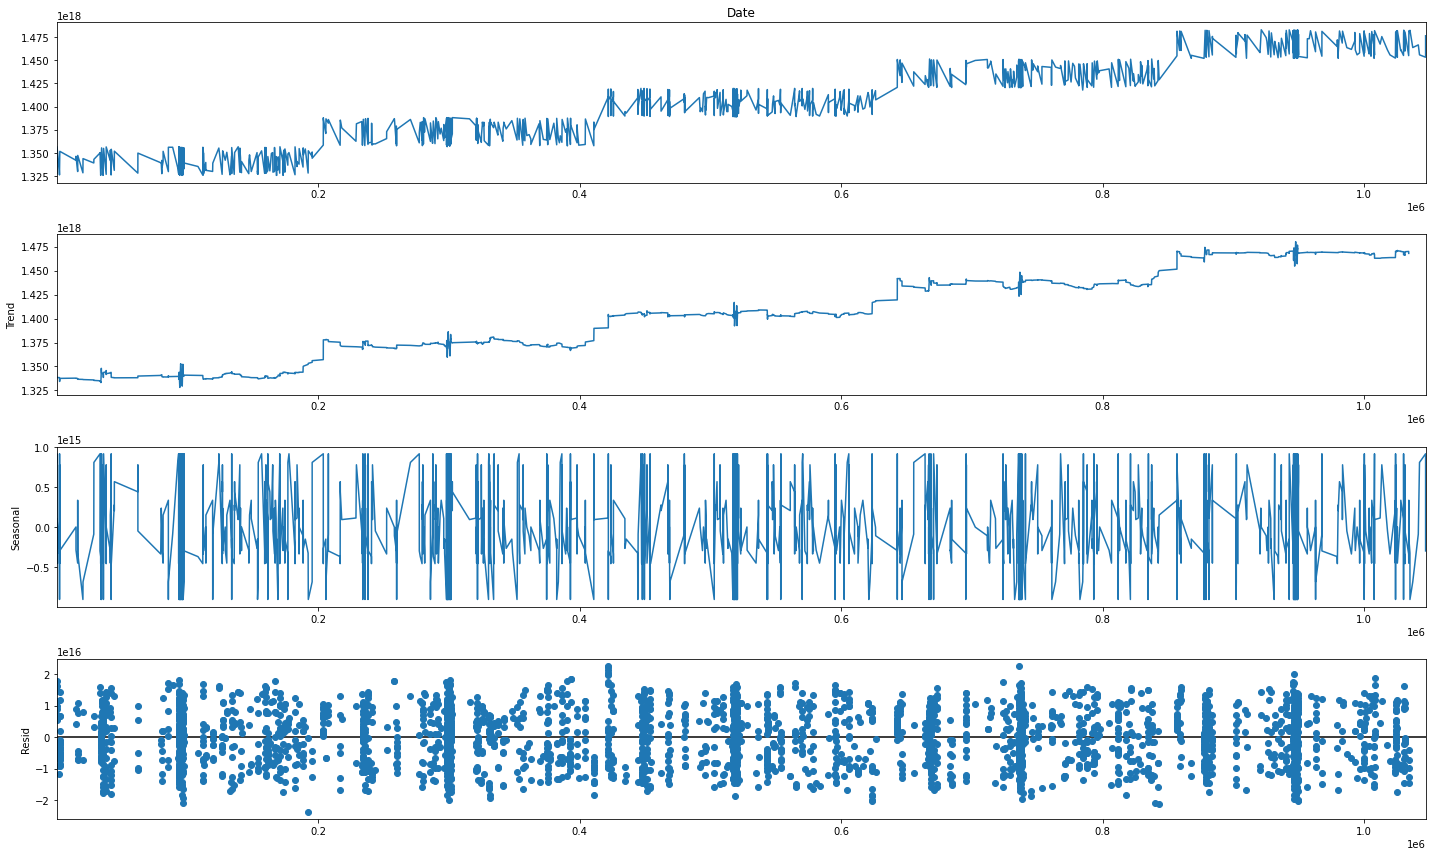

In [83]:
plt.figure(figsize = (50,20))
plt.scatter(df_1512['Date'], df_1512['Order_Demand'])
plt.xlabel('Date', fontsize=35)
plt.ylabel('Sales', fontsize=35)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.title('Product_1512', fontsize=35)
plt.show()
decomp_1512 = seasonal_decompose(df_1512['Date'], model='additive', period=30)
decomp_1512.plot()
mpl.rcParams['figure.figsize'] = (20, 12)
plt.show()

From each trend gained through the decomposition analysis, it looks as though the decomposition model worked moderately well for some of the products. However, specifically for product 0560, the decomposition trend didn't seem to point in the right direction, as it looked as though sales were seemingly decreasing overtime. At this point, due to time constraints I could not find a proper way to predict future values with this method, nor could I find a way to test the overall effectiveness of this model. 

For the second analysis that I wished to do, I wanted to find a way to perform gradient-boosted regression on this dataset, since I had some success with it in the previous project. Unfortunately, I could not find a way to convert the datetime data into a format of days that I could use for a regression model, so my analysis was unable to be finished. My initial plan for this transformation would have been to iterate over all rows of each product to find the difference of time in days for each row and add the previous row to the current one. This would effectively turn the datetime data into a numbered list of days. 

In [74]:
#Gradient boosting attempt starts here
# df_1900['Day'] = df_1900['Date'].dt.day
diff = -(df_1900['Date'].iloc[0] - df_1900['Date'].iloc[-1]).days
diff

1696

In [ ]:
TSS = TimeSeriesSplit(n_splits=5) #5 seemed like a good number, since 1/6 of the data would be left to test on.
Grad = GradientBoostingRegressor()